In [1]:
# Importing necessary Libraries
import numpy as np
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import warnings

from scipy.stats import kurtosis, skew

In [2]:
warnings.filterwarnings("ignore")
plt.style.use('tableau-colorblind10')

## Dataset
The goal of this project is to `predict the potentially fraudulent providers` based on the claims filed by them.along with this, we will also discover important variables helpful in detecting the behaviour of potentially fraud providers. further, we will study fraudulent patterns in the provider's claims to understand the future behaviour of providers.

For the purpose of this project, we are considering Inpatient claims, Outpatient claims and Beneficiary details of each provider. Lets s see their details :

1) **Inpatient Data:** This data provides insights about the claims filed for those patients who are admitted in the hospitals. It also provides additional details like their admission and discharge dates and admit d diagnosis code.

2) **Outpatient Data:** This data provides details about the claims filed for those patients who visit hospitals and not admitted in it.

3) **Beneficiary Details Data:** This data contains beneficiary KYC details like health conditions,regioregion they belong to etc.

I will be reading the data using `Polars` both training and testing data.

In [3]:
# Reading Train data
train_beneficiary = pl.read_csv("../data/Train_Beneficiarydata.csv")
train_inpatient = pl.read_csv("../data/Train_Inpatientdata.csv", ignore_errors=True)
train_outpatient = pl.read_csv("../data/Train_Outpatientdata.csv")
train = pl.read_csv("../data/Train.csv")

# Reading Test data
test_beneficiary = pl.read_csv("../data/Test_Beneficiarydata.csv")
test_inpatient = pl.read_csv("../data/Test_Inpatientdata.csv", ignore_errors=True)
test_outpatient = pl.read_csv("../data/Test_Outpatientdata.csv")
test = pl.read_csv("../data/Test.csv")

In [4]:
print(f"Shape of Train_Beneficiarydata: {train_beneficiary.shape}")
print(f"Shape of Train Outpatient: {train_outpatient.shape}")
print(f"Shape of Train Inpatient: {train_inpatient.shape}")
print(f"Shape of Train: {train.shape}")
print("="*50)
print(f"Shape of Test_Beneficiarydata: {test_beneficiary.shape}")
print(f"Shape of Test Inpatient: {test_inpatient.shape}")
print(f"Shape of Test Outpatient: {test_outpatient.shape}")
print(f"Shape of Test: {test.shape}")

Shape of Train_Beneficiarydata: (138556, 25)
Shape of Train Outpatient: (517737, 27)
Shape of Train Inpatient: (40474, 30)
Shape of Train: (5410, 2)
Shape of Test_Beneficiarydata: (63968, 25)
Shape of Test Inpatient: (9551, 30)
Shape of Test Outpatient: (125841, 27)
Shape of Test: (1353, 1)


In [5]:
print(f"Columns in Train_Beneficiarydata: {train_beneficiary.columns}")

Columns in Train_Beneficiarydata: ['BeneID', 'DOB', 'DOD', 'Gender', 'Race', 'RenalDiseaseIndicator', 'State', 'County', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease', 'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression', 'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt']


In [6]:
train_beneficiary.schema

Schema([('BeneID', String),
        ('DOB', String),
        ('DOD', String),
        ('Gender', Int64),
        ('Race', Int64),
        ('RenalDiseaseIndicator', String),
        ('State', Int64),
        ('County', Int64),
        ('NoOfMonths_PartACov', Int64),
        ('NoOfMonths_PartBCov', Int64),
        ('ChronicCond_Alzheimer', Int64),
        ('ChronicCond_Heartfailure', Int64),
        ('ChronicCond_KidneyDisease', Int64),
        ('ChronicCond_Cancer', Int64),
        ('ChronicCond_ObstrPulmonary', Int64),
        ('ChronicCond_Depression', Int64),
        ('ChronicCond_Diabetes', Int64),
        ('ChronicCond_IschemicHeart', Int64),
        ('ChronicCond_Osteoporasis', Int64),
        ('ChronicCond_rheumatoidarthritis', Int64),
        ('ChronicCond_stroke', Int64),
        ('IPAnnualReimbursementAmt', Int64),
        ('IPAnnualDeductibleAmt', Int64),
        ('OPAnnualReimbursementAmt', Int64),
        ('OPAnnualDeductibleAmt', Int64)])

In [7]:
def get_stats(df):
    df = df.with_columns([
        pl.when(pl.col(col) == "NA").then(None).otherwise(pl.col(col)).alias(col)
        if df[col].dtype == pl.Utf8 else df[col]
        for col in df.columns
    ])
    
    n_rows = df.shape[0]
    columns = df.columns
    dtypes = df.dtypes
    total_cnt = df.select(pl.col("*").drop_nulls().count())
    null_cnt = df.select([
        (n_rows - pl.col(col).drop_nulls().count()).alias(f"{col}_null_count")
        for col in df.columns
    ])
    missing_perc = null_cnt.with_columns([
        (pl.col(col) / n_rows * 100).alias(f"{col}_missing_percentage")
        for col in null_cnt.columns
    ])
    unq_vals = {col: df[col].n_unique() for col in df.columns}
    total_unqs = {col: df[col].unique().to_list() for col in df.columns}
    numeric_cols = df.select(pl.col(pl.Int64) | pl.col(pl.Float64))

    if numeric_cols.columns:
        kurtosis_vals = {}
        skewness_vals = {}

        for col in numeric_cols.columns:
            data = numeric_cols.select(pl.col(col)).to_numpy().flatten()
            kurtosis_vals[col] = kurtosis(data)
            skewness_vals[col] = skew(data)

        kurtosis_list = [kurtosis_vals.get(col, None) for col in df.columns]
        skewness_list = [skewness_vals.get(col, None) for col in df.columns]
    else:
        kurtosis_list = [None] * len(df.columns)
        skewness_list = [None] * len(df.columns)

    summary = pl.DataFrame({
        "Columns": columns,
        "Data Type": dtypes,
        "Non-Null count": [total_cnt[col][0] for col in df.columns],
        "Null count": [null_cnt[f"{col}_null_count"][0] for col in df.columns],
        "Missing Percentage (%)": [missing_perc[f"{col}_null_count_missing_percentage"][0] for col in df.columns],
        "Number of Unique Values": [unq_vals[col] for col in df.columns],
        "Sample Unique Values": [total_unqs[col] for col in df.columns]
    }, strict=False)

    summary = summary.with_columns([
        pl.Series("Kurtosis", kurtosis_list),
        pl.Series("Skewness", skewness_list)
    ])

    return summary

In [8]:
beneficiary_stats = get_stats(train_beneficiary)

In [9]:
beneficiary_stats

Columns,Data Type,Non-Null count,Null count,Missing Percentage (%),Number of Unique Values,Sample Unique Values,Kurtosis,Skewness
str,object,i64,i64,f64,i64,list[str],f64,f64
"""BeneID""",String,138556,0,0.0,138556,"[""BENE118786"", ""BENE137506"", … ""BENE113084""]",null,null
"""DOB""",String,138556,0,0.0,900,"[""1935-07-01"", ""1929-12-01"", … ""1981-07-01""]",null,null
"""DOD""",String,1421,137135,98.974422,12,"[""2009-09-01"", ""2009-08-01"", … ""2009-11-01""]",null,null
"""Gender""",Int64,138556,0,0.0,2,"[""1"", ""2""]",-1.917846,-0.286625
"""Race""",Int64,138556,0,0.0,4,"[""1"", ""2"", … ""5""]",14.006224,3.58442
…,…,…,…,…,…,…,…,…
"""ChronicCond_stroke""",Int64,138556,0,0.0,2,"[""1"", ""2""]",7.73474,-3.120055
"""IPAnnualReimbursementAmt""",Int64,138556,0,0.0,3004,"[""-8000"", ""-1400"", … ""161470""]",31.024055,4.636492
"""IPAnnualDeductibleAmt""",Int64,138556,0,0.0,147,"[""0"", ""1068"", … ""38272""]",268.099503,10.453149


**INTERPRETATION**



In [10]:
has_nulls = beneficiary_stats.filter(pl.col("Null count") > 0)

print("Columns with null values:")
print(has_nulls.select(["Columns", "Null count", "Missing Percentage (%)"]))

Columns with null values:
shape: (1, 3)
┌─────────┬────────────┬────────────────────────┐
│ Columns ┆ Null count ┆ Missing Percentage (%) │
│ ---     ┆ ---        ┆ ---                    │
│ str     ┆ i64        ┆ f64                    │
╞═════════╪════════════╪════════════════════════╡
│ DOD     ┆ 137135     ┆ 98.974422              │
└─────────┴────────────┴────────────────────────┘


In [11]:
# Number of unique beneficiaries in Training Data
beneficiary_row = beneficiary_stats.filter(pl.col("Columns") == "BeneID")
unique_beneficiaries = beneficiary_row.select(pl.col("Number of Unique Values")).item()

print(f"Number of unique beneficiaries in the dataset: {unique_beneficiaries}")

Number of unique beneficiaries in the dataset: 138556


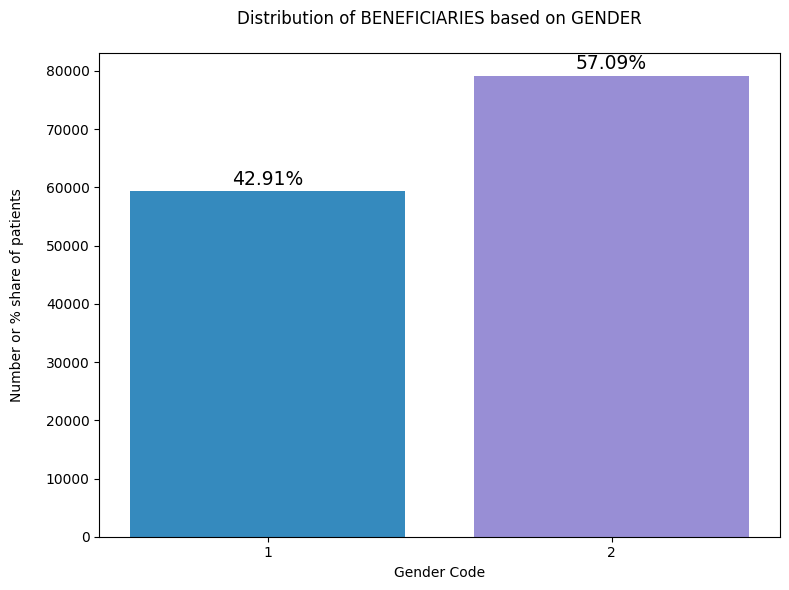

In [12]:
# Gender distribution transformation (1: Male, 2: Female)

gender_counts = (
    train_beneficiary
    .group_by("Gender")
    .agg(pl.len().alias("count"))
    .sort("Gender")
)

gender_pd = gender_counts.to_pandas()

plt.figure(figsize=(8, 6))
fig = plt.bar(
    gender_pd["Gender"].astype(str),
    gender_pd["count"],
    color=['#358ABE', '#988ED5']
)

total = gender_pd["count"].sum()
for i, count in enumerate(gender_pd["count"]):
    percentage = round((count / total) * 100, 2)
    plt.text(i, count * 1.015, f'{percentage}%', ha='center', fontsize=13.5)

plt.xlabel("Gender Code")
plt.ylabel("Number or % share of patients\n")
plt.title("Distribution of BENEFICIARIES based on GENDER\n")
plt.tight_layout()
plt.show()

In [13]:
# Calculating Age from DOB
train_beneficiary = train_beneficiary.with_columns(
    pl.col("DOB").str.strptime(pl.Date, "%Y-%m-%d").alias("DOB")
)
train_beneficiary = train_beneficiary.with_columns(
    pl.col("DOB").dt.year().alias("Patient_Age_Year"),
    pl.col("DOB").dt.month().alias("Patient_Age_Month")
)

In [14]:
bene_age_year_df = (
    train_beneficiary
    .with_columns(
        ((pl.col("Patient_Age_Year") // 5) * 5).alias("Age_Group_Start")
    )
    .group_by("Age_Group_Start")
    .agg(pl.len().alias("num_of_beneficiaries"))
    .sort("Age_Group_Start")
    .with_columns(
        (pl.col("Age_Group_Start").cast(str) + "-" + (pl.col("Age_Group_Start") + 4).cast(str)).alias("Age_Group")
    )
    .select(["Age_Group", "num_of_beneficiaries"])
)

bene_age_year_pd = bene_age_year_df.to_pandas()

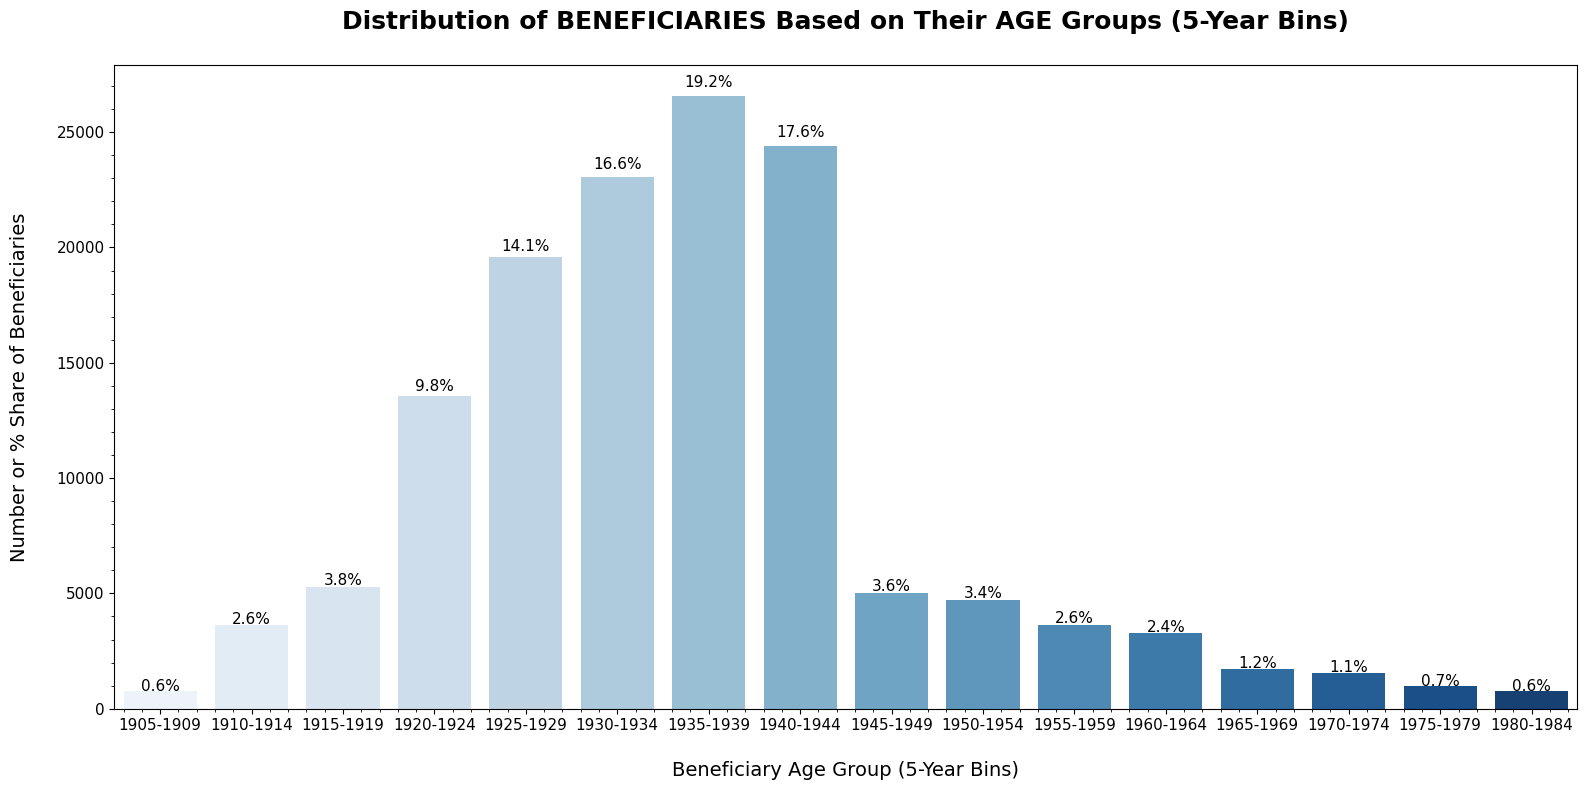

In [15]:
plt.figure(figsize=(16, 8))

fig = sns.barplot(data=bene_age_year_pd, x='Age_Group', y='num_of_beneficiaries', palette='Blues')

total_beneficiaries = train_beneficiary.shape[0]
for p in fig.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    percentage = round((height * 100) / total_beneficiaries, 1)
    fig.annotate(f'{percentage}%', (x + width / 2, y + height * 1.015), ha='center', fontsize=11)

plt.xlabel("\nBeneficiary Age Group (5-Year Bins)", fontsize=14)
plt.ylabel("Number or % Share of Beneficiaries\n", fontsize=14)
plt.title("Distribution of BENEFICIARIES Based on Their AGE Groups (5-Year Bins)\n", fontsize=18, weight='bold')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.minorticks_on()
plt.tight_layout()
plt.show()

**INTERPRETATION**



In [16]:
bene_birth_month_df = (
    train_beneficiary
    .select("Patient_Age_Month")
    .group_by("Patient_Age_Month")
    .agg(pl.len().alias("num_of_beneficiaries"))
    .sort("Patient_Age_Month")
    .rename({"Patient_Age_Month": "Birth_Month"})
)

bene_birth_month_pd = bene_birth_month_df.to_pandas()

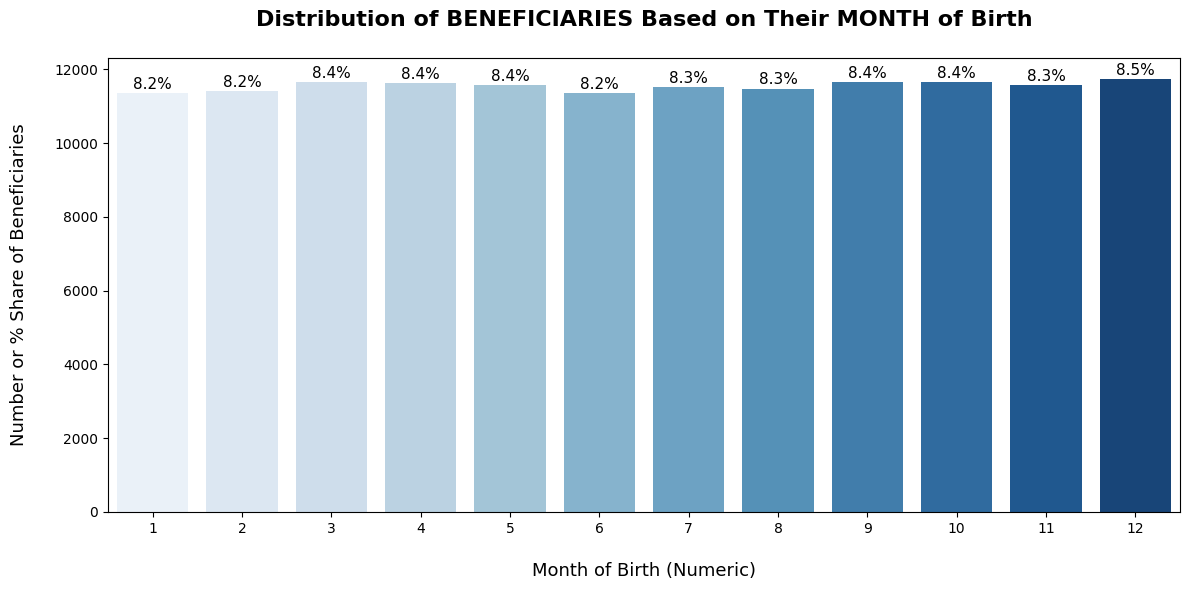

In [17]:
plt.figure(figsize=(12, 6))
fig = sns.barplot(data=bene_birth_month_pd, x='Birth_Month', y='num_of_beneficiaries', palette='Blues')

total_beneficiaries = train_beneficiary.shape[0]
for p in fig.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    percentage = round((height * 100) / total_beneficiaries, 1)
    fig.annotate(f'{percentage}%', (x + width / 2, y + height * 1.01),
                 ha='center', fontsize=11)

plt.xlabel("\nMonth of Birth (Numeric)", fontsize=13)
plt.ylabel("Number or % Share of Beneficiaries\n", fontsize=13)
plt.title("Distribution of BENEFICIARIES Based on Their MONTH of Birth\n", fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

**INTERPRETATION**



In [18]:
# Adding "Dead_or_Alive" column (1: Dead, 0: Alive)
train_beneficiary = train_beneficiary.with_columns(
    pl.when(pl.col("DOD").str.strptime(pl.Date, strict=False).is_not_null())
    .then(1)
    .otherwise(0)
    .alias("Dead_or_Alive")
)

In [19]:
total = train_beneficiary.height

dead_alive_stats = (
    train_beneficiary
    .group_by("Dead_or_Alive")
    .agg([
        pl.len().alias("count"),
        (pl.len() * 100 / total).alias("percentage")
    ])
    .sort("Dead_or_Alive")
)

dead_alive_stats

Dead_or_Alive,count,percentage
i32,u32,f64
0,137135,98.974422
1,1421,1.025578


In [20]:
# Ensuring "DOD" and "DOB" are in Date format
train_beneficiary = train_beneficiary.with_columns([
    pl.col("DOD").cast(pl.Utf8).str.strptime(pl.Date, "%Y-%m-%d", strict=False),
    pl.col("DOB").cast(pl.Utf8).str.strptime(pl.Date, "%Y-%m-%d", strict=False)
])

In [21]:
# Filling NaN values in "DOD" column with the latest known death date
max_dod = train_beneficiary.select(pl.col("DOD").drop_nulls().max()).item()

train_beneficiary = train_beneficiary.with_columns(
    pl.col("DOD").fill_null(pl.lit(max_dod))
)

In [22]:
# Compute AGE only for non-null DOD
train_beneficiary = train_beneficiary.with_columns(
    pl.when(pl.col("DOD").is_not_null())
    .then(((pl.col("DOD") - pl.col("DOB")).dt.total_days() / 365.0).round(1))
    .alias("AGE")
)

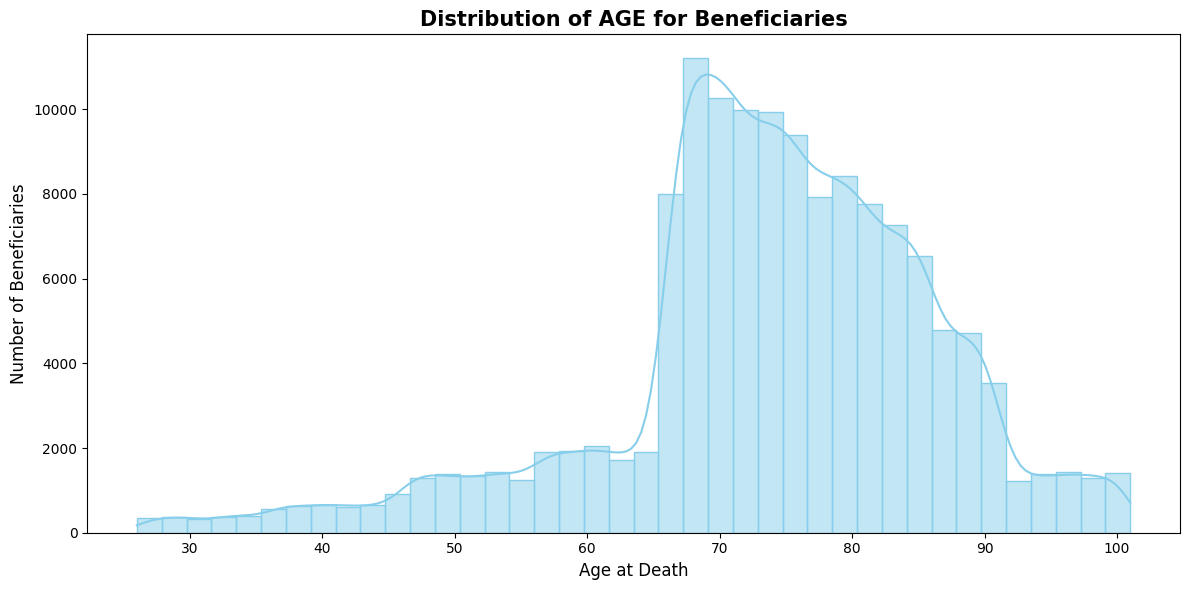

In [23]:
age_df = (
    train_beneficiary
    .select("AGE")
    .filter(pl.col("AGE").is_not_null())
    .to_pandas()
)

plt.figure(figsize=(12, 6))
sns.histplot(age_df["AGE"], bins=40, kde=True, color='skyblue', edgecolor='skyblue')

plt.title("Distribution of AGE for Beneficiaries", fontsize=15, weight='bold')
plt.xlabel("Age at Death", fontsize=12)
plt.ylabel("Number of Beneficiaries", fontsize=12)
plt.tight_layout()
plt.show()

In [24]:
train_beneficiary.select("AGE").describe()

statistic,AGE
str,f64
"""count""",138556.0
"""null_count""",0.0
"""mean""",73.632756
"""std""",12.736605
"""min""",26.0
"""25%""",68.0
"""50%""",74.3
"""75%""",82.0
"""max""",101.0


In [25]:
train_beneficiary = train_beneficiary.with_columns(
    pl.when((pl.col("AGE") >= 1) & (pl.col("AGE") <= 40)).then(pl.lit("Young"))
    .when((pl.col("AGE") > 40) & (pl.col("AGE") <= 60)).then(pl.lit("Mid"))
    .when((pl.col("AGE") > 60) & (pl.col("AGE") <= 80)).then(pl.lit("Old"))
    .otherwise(pl.lit("Very Old"))
    .alias("AGE_groups")
)

In [26]:
# Gender and Race Distribution
train_beneficiary.select("Race").unique()

Race
i64
3
1
2
5


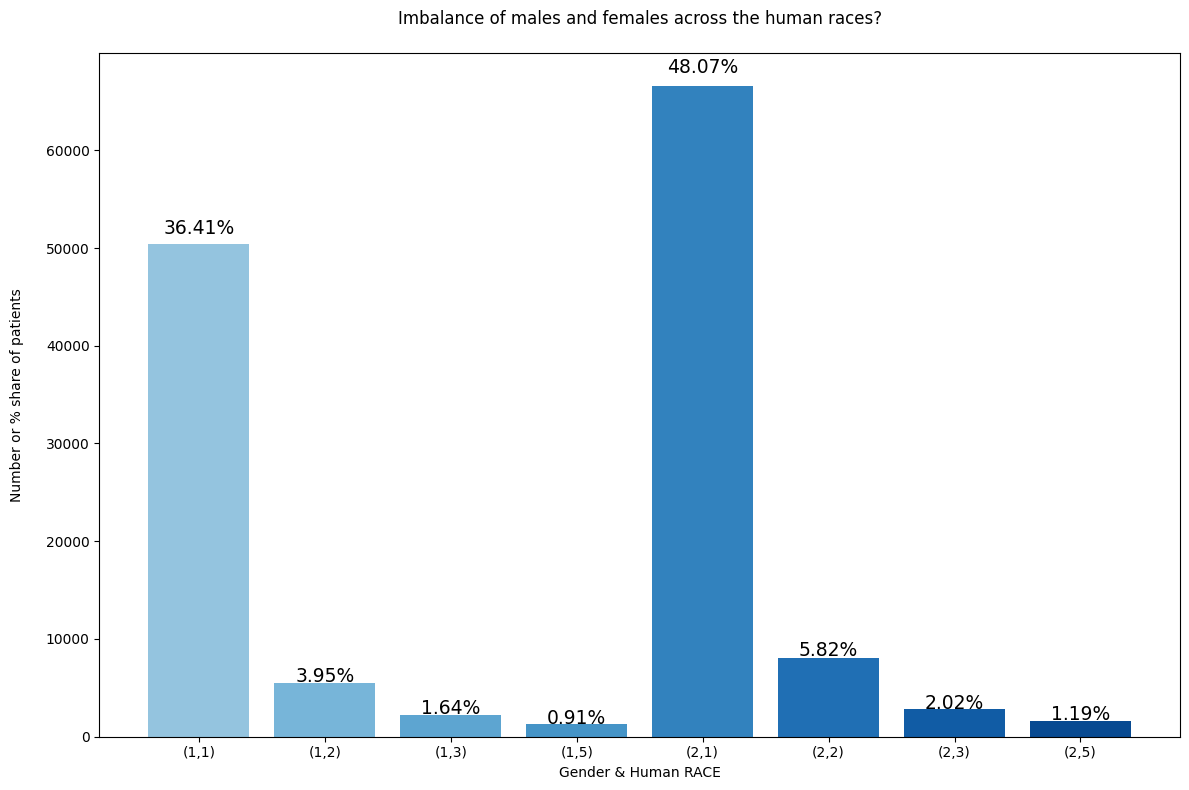

In [27]:
grouped = (
    train_beneficiary
    .group_by(["Gender", "Race"])
    .agg(pl.count("AGE").alias("count"))
    .sort(["Gender", "Race"])
)

counts = grouped["count"].to_list()
total = train_beneficiary.height
labels = list(zip(grouped["Gender"].to_list(), grouped["Race"].to_list()))

num_bars = len(counts)
blue_shades = cm.Blues(np.linspace(0.4, 0.9, num_bars)) 

plt.figure(figsize=(12, 8))
bars = plt.bar(range(num_bars), counts, color=blue_shades)


for bar in bars:
    height = bar.get_height()
    x = bar.get_x()
    width = bar.get_width()
    plt.annotate(
        f'{round((height * 100) / total, 2)}%',
        (x + width / 2, height * 1.02),
        ha='center',
        fontsize=13.5
    )

plt.xlabel("Gender & Human RACE")
plt.xticks(
    ticks=range(num_bars),
    labels=[f"({g},{r})" for g, r in labels]
)
plt.ylabel("Number or % share of patients\n")
plt.title("Imbalance of males and females across the human races?\n")
plt.tight_layout()
plt.show()

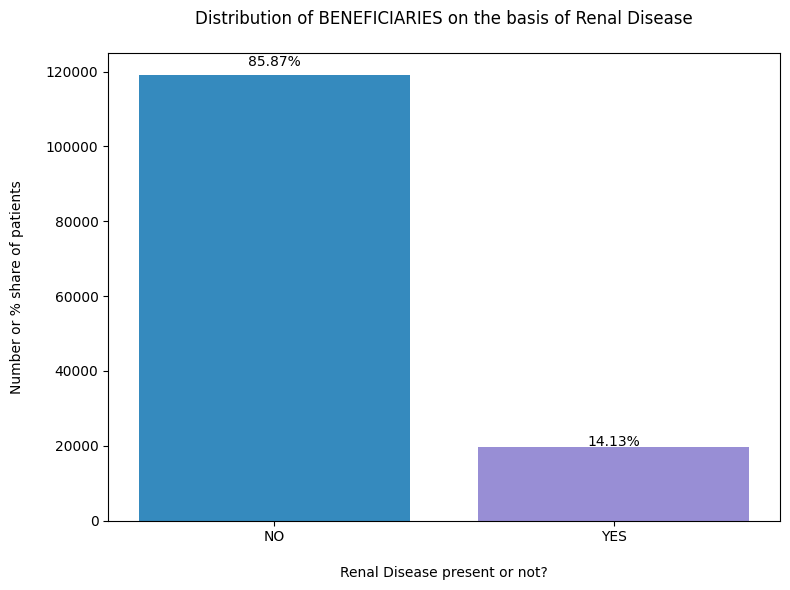

In [28]:
renal_counts = (
    train_beneficiary
    .group_by("RenalDiseaseIndicator")
    .agg(pl.count().alias("count"))
    .sort("RenalDiseaseIndicator")
)

values = renal_counts["count"].to_list()
labels = renal_counts["RenalDiseaseIndicator"].to_list()

plt.figure(figsize=(8, 6))
bars = plt.bar(range(len(values)), values, color=['#358ABE', '#988ED5'])

total = sum(values)
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.annotate(
        f'{round((height * 100) / total, 2)}%',
        (bar.get_x() + bar.get_width() / 2, height * 1.02),
        ha='center',
        fontsize=10
    )

plt.xlabel("\nRenal Disease present or not?")
plt.xticks(ticks=[0, 1], labels=["NO", "YES"], size=10)
plt.ylabel("Number or % share of patients\n")
plt.title("Distribution of BENEFICIARIES on the basis of Renal Disease\n")
plt.tight_layout()
plt.show()

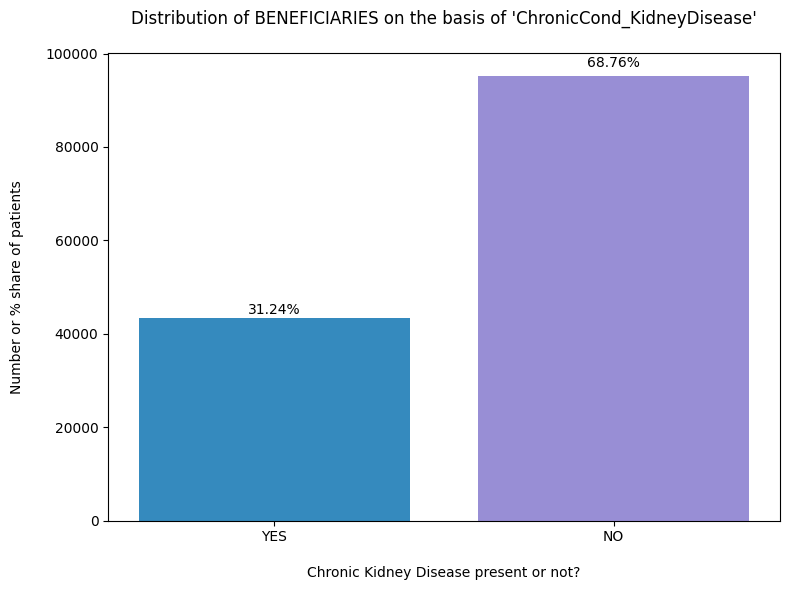

In [29]:
kidney_counts = (
    train_beneficiary
    .group_by("ChronicCond_KidneyDisease")
    .agg(pl.count().alias("count"))
    .sort("ChronicCond_KidneyDisease")
)

values = kidney_counts["count"].to_list()
raw_labels = kidney_counts["ChronicCond_KidneyDisease"].to_list()
labels = ["NO" if val == 2 else "YES" for val in raw_labels]

plt.figure(figsize=(8, 6))
bars = plt.bar(range(len(values)), values, color=['#358ABE', '#988ED5'])

total = sum(values)
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.annotate(
        f'{round((height * 100) / total, 2)}%',
        (bar.get_x() + bar.get_width() / 2, height * 1.02),
        ha='center',
        fontsize=10
    )

plt.xlabel("\nChronic Kidney Disease present or not?")
plt.xticks(ticks=range(len(labels)), labels=labels, size=10)
plt.ylabel("Number or % share of patients\n")
plt.title("Distribution of BENEFICIARIES on the basis of 'ChronicCond_KidneyDisease'\n")
plt.tight_layout()
plt.show()

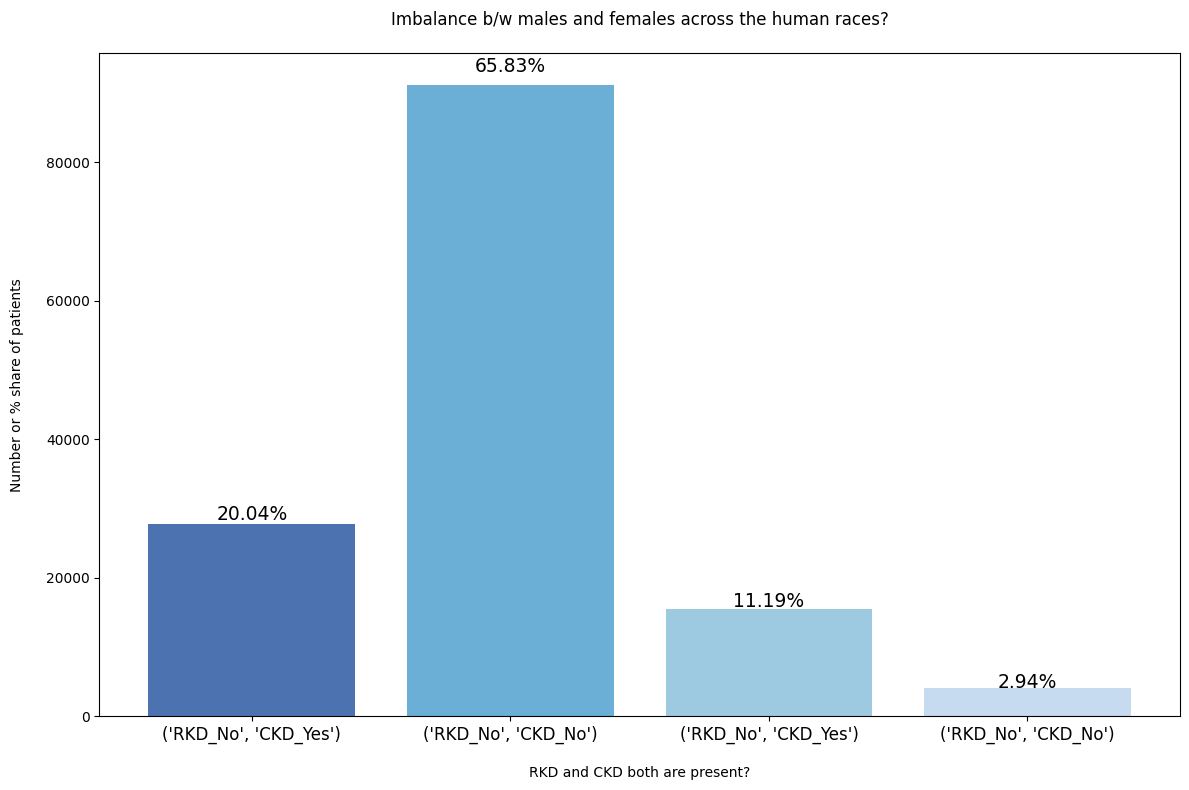

In [30]:
combo_counts = (
    train_beneficiary
    .group_by(["RenalDiseaseIndicator", "ChronicCond_KidneyDisease"])
    .agg(pl.count("Gender").alias("count"))
    .sort(by=["RenalDiseaseIndicator", "ChronicCond_KidneyDisease"])
)

values = combo_counts["count"].to_list()

rkd_ckd_labels = []
for rkd, ckd in zip(combo_counts["RenalDiseaseIndicator"], combo_counts["ChronicCond_KidneyDisease"]):
    label = (
        ("RKD_Yes" if rkd == 1 else "RKD_No"),
        ("CKD_Yes" if ckd == 1 else "CKD_No")
    )
    rkd_ckd_labels.append(label)

plt.figure(figsize=(12, 8))
bars = plt.bar(range(len(values)), values, color=['#4c72b0', '#6baed6', '#9ecae1', '#c6dbef']) 

total = sum(values)
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.annotate(
        f'{round((height * 100) / total, 2)}%',
        (bar.get_x() + bar.get_width() / 2, height * 1.02),
        ha='center',
        fontsize=13.5
    )

plt.xlabel("\nRKD and CKD both are present?")
plt.xticks(ticks=range(len(rkd_ckd_labels)), labels=rkd_ckd_labels, rotation=0, size=12)
plt.ylabel("Number or % share of patients\n")
plt.title("Imbalance b/w males and females across the human races?\n")
plt.tight_layout()
plt.show()

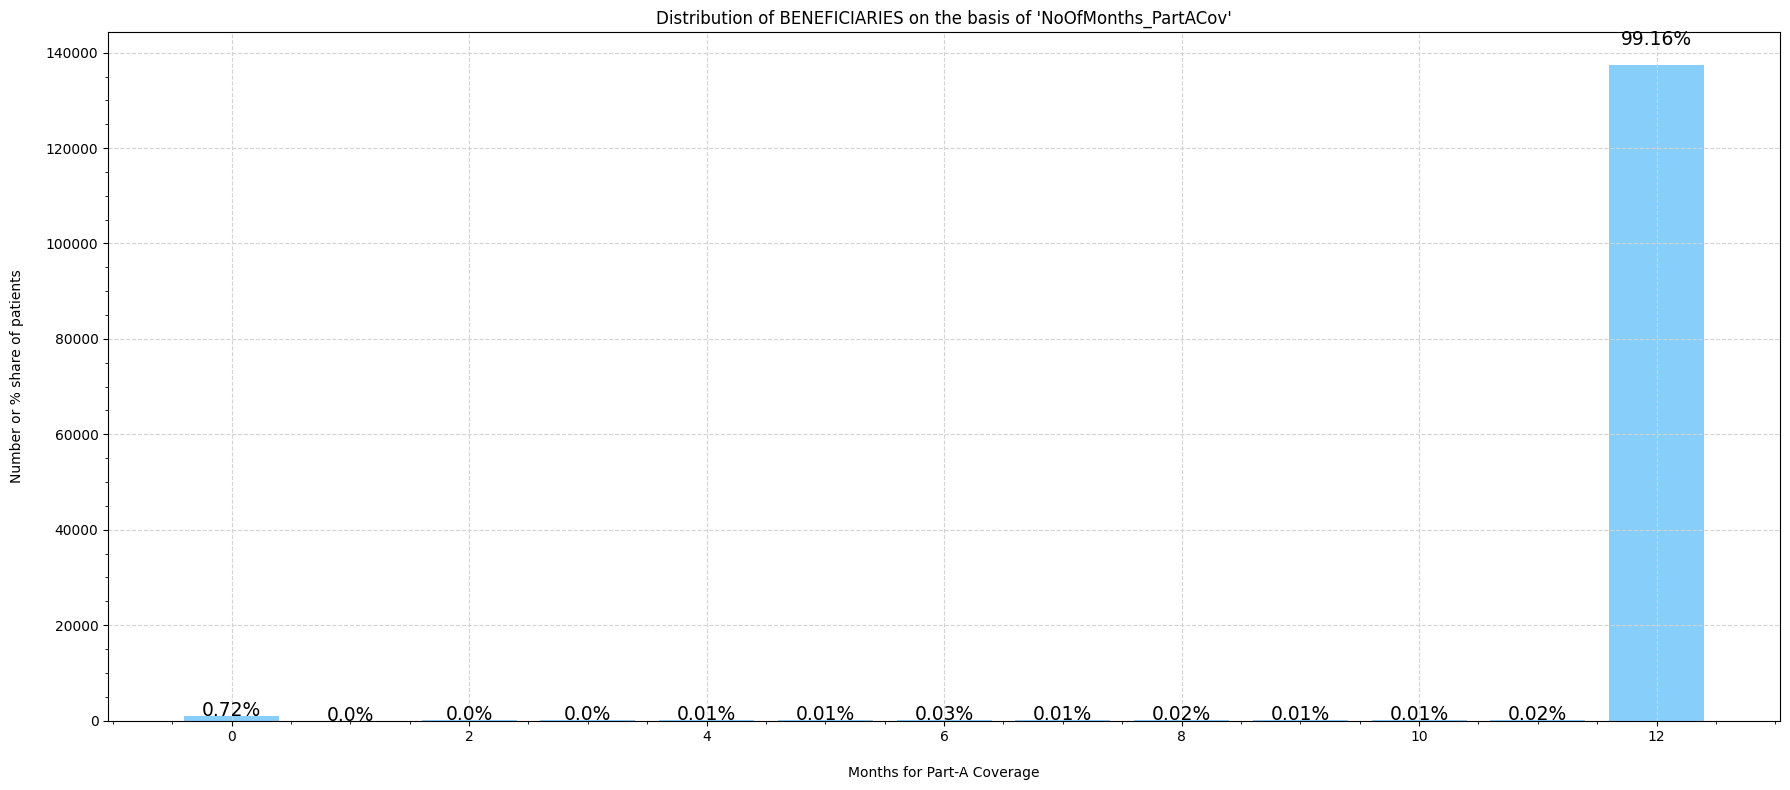

In [31]:
part_a_counts = (
    train_beneficiary
    .group_by("NoOfMonths_PartACov")
    .agg(pl.count().alias("count"))
    .sort("NoOfMonths_PartACov")
)

values = part_a_counts["count"].to_list()
labels = part_a_counts["NoOfMonths_PartACov"].to_list()

plt.figure(figsize=(18, 8))
bars = plt.bar(labels, values, color='lightskyblue')

total = sum(values)
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.annotate(
        f'{round((height * 100) / total, 2)}%',
        (bar.get_x() + bar.get_width() / 2, height * 1.03),
        ha='center',
        fontsize=13.5,
    )

plt.xlabel("\nMonths for Part-A Coverage")
plt.ylabel("Number or % share of patients\n")
plt.grid(which='major', linestyle="--", color='lightgrey')
plt.minorticks_on()
plt.title("Distribution of BENEFICIARIES on the basis of 'NoOfMonths_PartACov'")
plt.tight_layout()
plt.show()

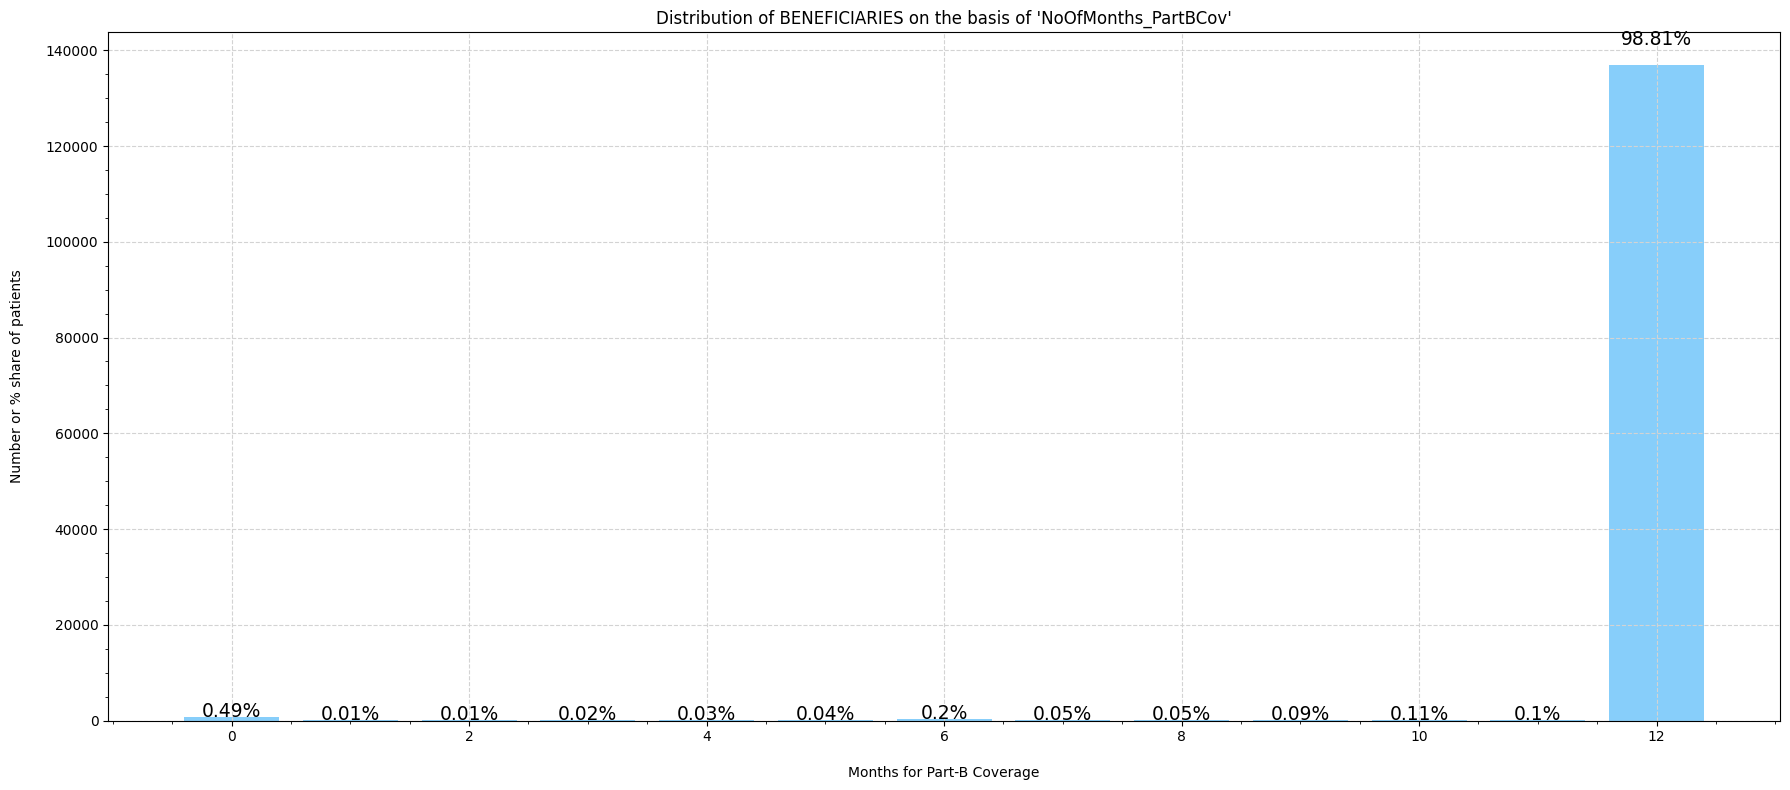

In [32]:
part_b_counts = (
    train_beneficiary
    .group_by("NoOfMonths_PartBCov")
    .agg(pl.count().alias("count"))
    .sort("NoOfMonths_PartBCov")
)

values = part_b_counts["count"].to_list()
labels = part_b_counts["NoOfMonths_PartBCov"].to_list()

plt.figure(figsize=(18, 8))
bars = plt.bar(labels, values, color='lightskyblue')

total = sum(values)
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.annotate(
        f'{round((height * 100) / total, 2)}%',
        (bar.get_x() + bar.get_width() / 2, height * 1.03),
        ha='center',
        fontsize=13.5,
    )

plt.xlabel("\nMonths for Part-B Coverage")
plt.ylabel("Number or % share of patients\n")
plt.grid(which='major', linestyle="--", color='lightgrey')
plt.minorticks_on()
plt.title("Distribution of BENEFICIARIES on the basis of 'NoOfMonths_PartBCov'")
plt.tight_layout()
plt.show()

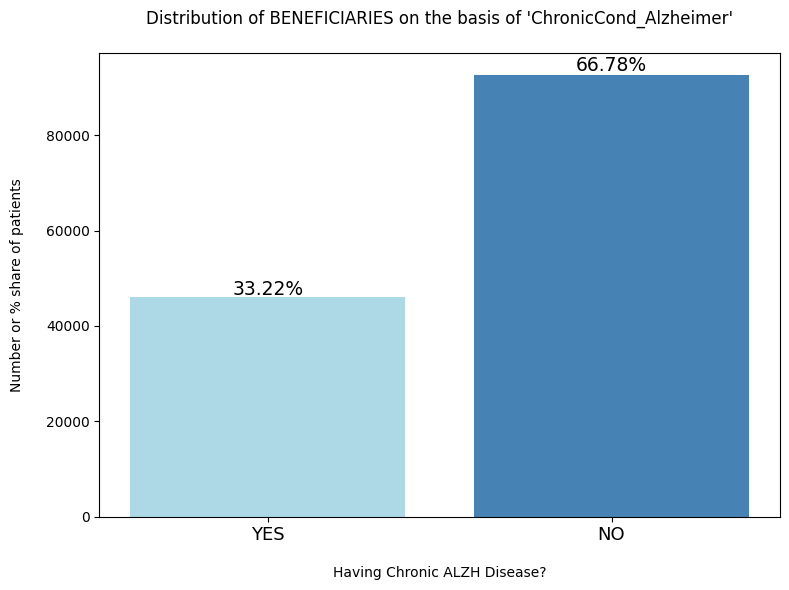

In [33]:
alz_counts = (
    train_beneficiary
    .group_by("ChronicCond_Alzheimer")
    .agg(pl.count().alias("count"))
    .sort("ChronicCond_Alzheimer")
)

values = alz_counts["count"].to_list()
labels_raw = alz_counts["ChronicCond_Alzheimer"].to_list()
labels = ["NO" if val == 2 else "YES" for val in labels_raw]

plt.figure(figsize=(8, 6))
bars = plt.bar(range(len(values)), values, color=['lightblue', 'steelblue'])

total = sum(values)
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.annotate(
        f'{round((height * 100) / total, 2)}%',
        (bar.get_x() + bar.get_width() / 2, height * 1.01),
        ha='center',
        fontsize=13.5
    )

plt.xlabel("\nHaving Chronic ALZH Disease?")
plt.xticks(ticks=[0, 1], labels=labels, fontsize=13)
plt.ylabel("Number or % share of patients\n")
plt.title("Distribution of BENEFICIARIES on the basis of 'ChronicCond_Alzheimer'\n")
plt.tight_layout()
plt.show()

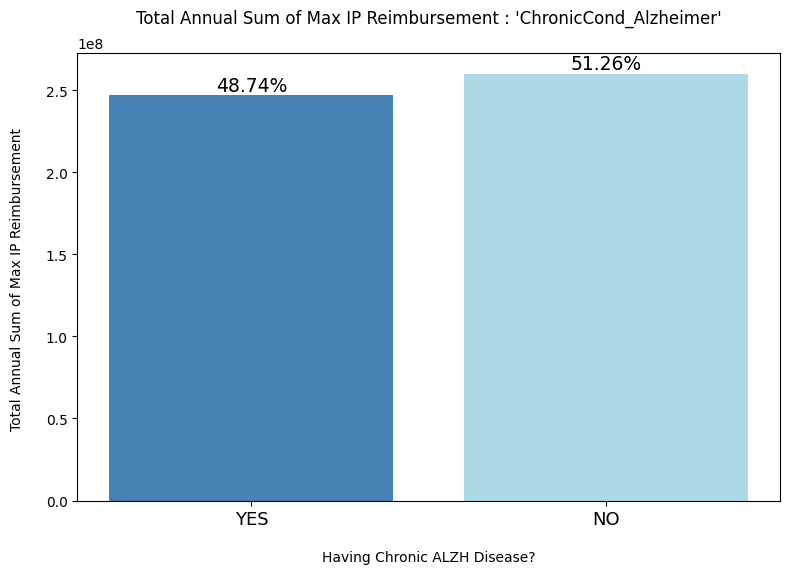

In [34]:
alz_reimbursement = (
    train_beneficiary
    .group_by("ChronicCond_Alzheimer")
    .agg(pl.sum("IPAnnualReimbursementAmt").alias("total_reimb"))
    .sort("ChronicCond_Alzheimer")
)

values = alz_reimbursement["total_reimb"].to_list()
labels_raw = alz_reimbursement["ChronicCond_Alzheimer"].to_list()
labels = ["YES" if val == 1 else "NO" for val in labels_raw]

plt.figure(figsize=(8, 6))
bars = plt.bar(range(len(values)), values, color=["steelblue", "lightblue"]) 

total = sum(values)
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.annotate(
        f'{round((height * 100) / total, 2)}%',
        (bar.get_x() + bar.get_width() / 2, height * 1.01),
        ha='center',
        fontsize=13.5,
        rotation=0
    )

plt.xlabel("\nHaving Chronic ALZH Disease?")
plt.xticks(ticks=range(len(labels)), labels=labels, fontsize=13)
plt.ylabel("Total Annual Sum of Max IP Reimbursement \n")
plt.title("Total Annual Sum of Max IP Reimbursement : 'ChronicCond_Alzheimer'\n")
plt.tight_layout()
plt.show()

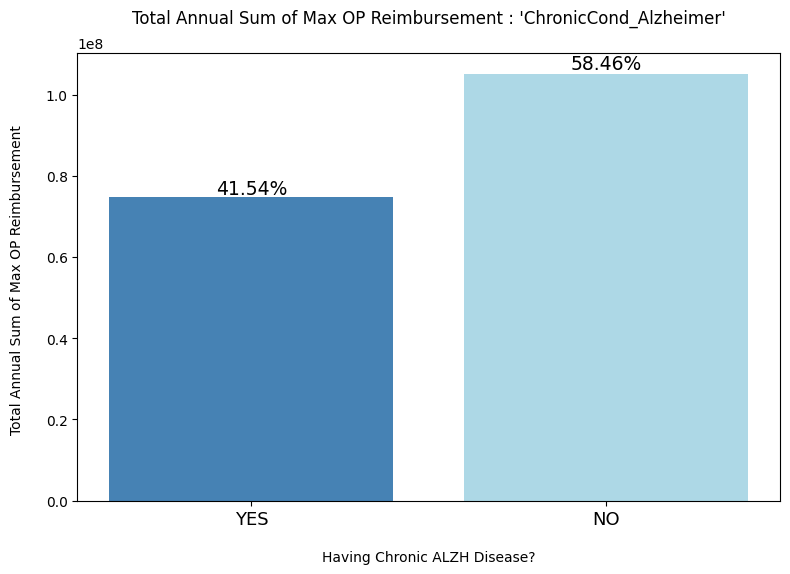

In [35]:
alz_op_reimbursement = (
    train_beneficiary
    .group_by("ChronicCond_Alzheimer")
    .agg(pl.sum("OPAnnualReimbursementAmt").alias("total_reimb"))
    .sort("ChronicCond_Alzheimer")
)

values = alz_op_reimbursement["total_reimb"].to_list()
labels_raw = alz_op_reimbursement["ChronicCond_Alzheimer"].to_list()
labels = ["YES" if val == 1 else "NO" for val in labels_raw]

plt.figure(figsize=(8, 6))
bars = plt.bar(range(len(values)), values, color=["steelblue", "lightblue"])

total = sum(values)
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.annotate(
        f'{round((height * 100) / total, 2)}%',
        (bar.get_x() + bar.get_width() / 2, height * 1.01),
        ha='center',
        fontsize=13.5,
        rotation=0
    )

plt.xlabel("\nHaving Chronic ALZH Disease?")
plt.xticks(ticks=range(len(labels)), labels=labels, fontsize=13)
plt.ylabel("Total Annual Sum of Max OP Reimbursement \n")
plt.title("Total Annual Sum of Max OP Reimbursement : 'ChronicCond_Alzheimer'\n")
plt.tight_layout()
plt.show()

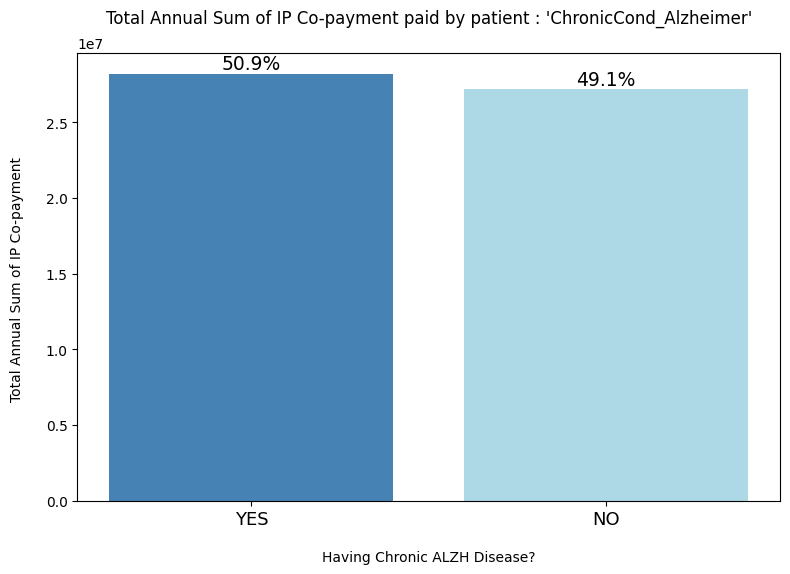

In [36]:
alz_ip_deductible = (
    train_beneficiary
    .group_by("ChronicCond_Alzheimer")
    .agg(pl.sum("IPAnnualDeductibleAmt").alias("total_deductible"))
    .sort("ChronicCond_Alzheimer")
)

values = alz_ip_deductible["total_deductible"].to_list()
labels_raw = alz_ip_deductible["ChronicCond_Alzheimer"].to_list()
labels = ["YES" if val == 1 else "NO" for val in labels_raw]

plt.figure(figsize=(8, 6))
bars = plt.bar(range(len(values)), values, color=["steelblue", "lightblue"])

total = sum(values)
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.annotate(
        f'{round((height * 100) / total, 2)}%',
        (bar.get_x() + bar.get_width() / 2, height * 1.01),
        ha='center',
        fontsize=13.5,
        rotation=0
    )

plt.xlabel("\nHaving Chronic ALZH Disease?")
plt.xticks(ticks=range(len(labels)), labels=labels, fontsize=13)
plt.ylabel("Total Annual Sum of IP Co-payment \n")
plt.title("Total Annual Sum of IP Co-payment paid by patient : 'ChronicCond_Alzheimer'\n")
plt.tight_layout()
plt.show()

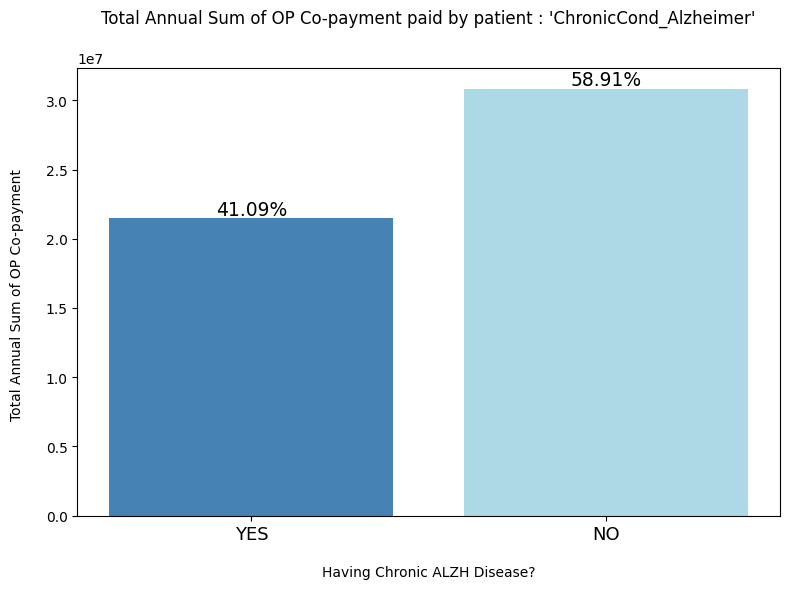

In [37]:
alz_op_deductible = (
    train_beneficiary
    .group_by("ChronicCond_Alzheimer")
    .agg(pl.sum("OPAnnualDeductibleAmt").alias("total_deductible"))
    .sort("ChronicCond_Alzheimer")
)

values = alz_op_deductible["total_deductible"].to_list()
labels_raw = alz_op_deductible["ChronicCond_Alzheimer"].to_list()
labels = ["YES" if val == 1 else "NO" for val in labels_raw]

plt.figure(figsize=(8, 6))
bars = plt.bar(range(len(values)), values, color=["steelblue", "lightblue"])

total = sum(values)
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.annotate(
        f'{round((height * 100) / total, 2)}%',
        (bar.get_x() + bar.get_width() / 2, height * 1.01),
        ha='center',
        fontsize=13.5,
        rotation=0
    )

plt.xlabel("\nHaving Chronic ALZH Disease?")
plt.xticks(ticks=range(len(labels)), labels=labels, fontsize=13)
plt.ylabel("Total Annual Sum of OP Co-payment \n")
plt.title("Total Annual Sum of OP Co-payment paid by patient : 'ChronicCond_Alzheimer'\n")
plt.tight_layout()
plt.show()

In [38]:
bene_count = (
    train_beneficiary
    .group_by("ChronicCond_Alzheimer")
    .agg(pl.count("BeneID").alias("BeneCount"))
    .sort("ChronicCond_Alzheimer")
)

In [39]:
bene_count

ChronicCond_Alzheimer,BeneCount
i64,u32
1,46026
2,92530


In [40]:
sum_metrics = (
    train_beneficiary
    .group_by("ChronicCond_Alzheimer")
    .agg([
        pl.sum("IPAnnualReimbursementAmt").alias("Total_IP_Reimb"),
        pl.sum("OPAnnualReimbursementAmt").alias("Total_OP_Reimb"),
        pl.sum("IPAnnualDeductibleAmt").alias("Total_IP_Deductible"),
        pl.sum("OPAnnualDeductibleAmt").alias("Total_OP_Deductible")
    ])
    .sort("ChronicCond_Alzheimer")
)


In [41]:
sum_metrics

ChronicCond_Alzheimer,Total_IP_Reimb,Total_OP_Reimb,Total_IP_Deductible,Total_OP_Deductible
i64,i64,i64,i64,i64
1,247213280,74721530,28200854,21502981
2,259949690,105154550,27200388,30832150


In [42]:
alz_combined = sum_metrics.join(bene_count, on="ChronicCond_Alzheimer")

alz_avg = alz_combined.with_columns([
    (pl.col("Total_IP_Reimb") / pl.col("BeneCount")).alias("AVG IP Reimbursement Amt"),
    (pl.col("Total_OP_Reimb") / pl.col("BeneCount")).alias("AVG OP Reimbursement Amt"),
    (pl.col("Total_IP_Deductible") / pl.col("BeneCount")).alias("AVG IP Co-payment Amt"),
    (pl.col("Total_OP_Deductible") / pl.col("BeneCount")).alias("AVG OP Co-payment Amt")
])

In [43]:
alz_plot_df = (
    alz_avg
    .select([
        "ChronicCond_Alzheimer",
        "AVG IP Reimbursement Amt",
        "AVG OP Reimbursement Amt",
        "AVG IP Co-payment Amt",
        "AVG OP Co-payment Amt"
    ])
    .sort("ChronicCond_Alzheimer")
    .to_pandas()
    .set_index("ChronicCond_Alzheimer")
)

<Figure size 1200x800 with 0 Axes>

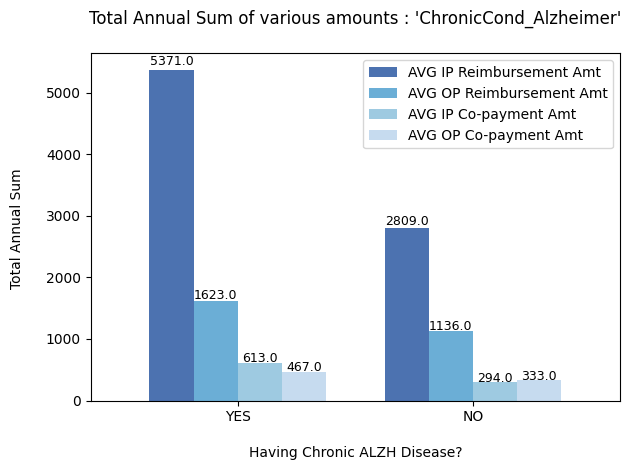

In [44]:
alz_plot_df.index = ["YES", "NO"] 

plt.figure(figsize=(12, 8))
fig = alz_plot_df.plot(kind='bar', color=["#4c72b0", "#6baed6", "#9ecae1", "#c6dbef"], width=0.75)

for bar in fig.patches:
    height = bar.get_height()
    x = bar.get_x()
    width = bar.get_width()
    fig.annotate(
        f'{round(height, 0)}',
        (x + width / 2, height * 1.015),
        ha='center',
        fontsize=9,
        rotation=0
    )

plt.xlabel("\nHaving Chronic ALZH Disease?")
plt.xticks(fontsize=10, rotation=0)
plt.ylabel("Total Annual Sum \n")
plt.title("Total Annual Sum of various amounts : 'ChronicCond_Alzheimer'\n")
plt.tight_layout()
plt.show()

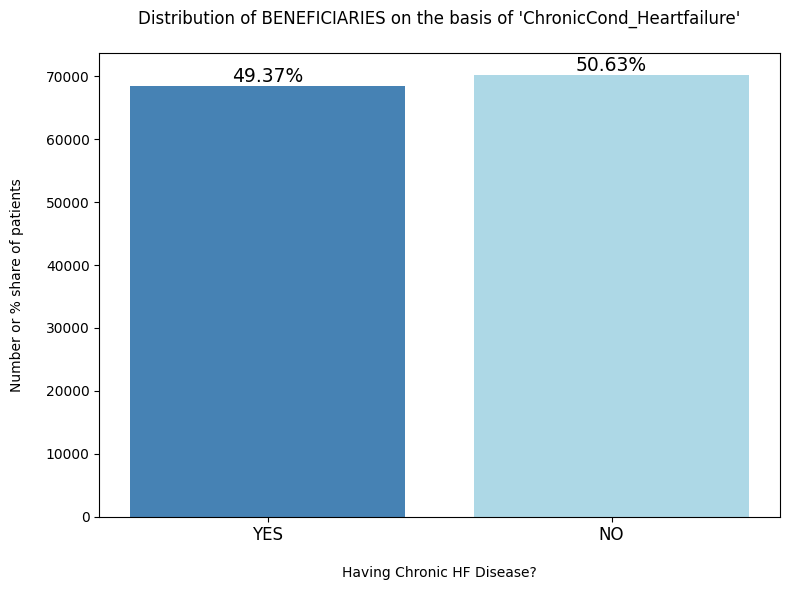

In [45]:
hf_counts = (
    train_beneficiary
    .group_by("ChronicCond_Heartfailure")
    .agg(pl.count("BeneID").alias("count"))
    .sort("ChronicCond_Heartfailure")
)

values = hf_counts["count"].to_list()
labels_raw = hf_counts["ChronicCond_Heartfailure"].to_list()
labels = ["YES" if val == 1 else "NO" for val in labels_raw]

plt.figure(figsize=(8, 6))
bars = plt.bar(range(len(values)), values, color=["steelblue", "lightblue"])

total = sum(values)
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.annotate(
        f'{round((height * 100) / total, 2)}%',
        (bar.get_x() + bar.get_width() / 2, height * 1.01),
        ha='center',
        fontsize=13.5,
        rotation=0
    )

plt.xlabel("\nHaving Chronic HF Disease?")
plt.xticks(ticks=range(len(labels)), labels=labels, fontsize=12)
plt.ylabel("Number or % share of patients\n")
plt.title("Distribution of BENEFICIARIES on the basis of 'ChronicCond_Heartfailure'\n")
plt.tight_layout()
plt.show()

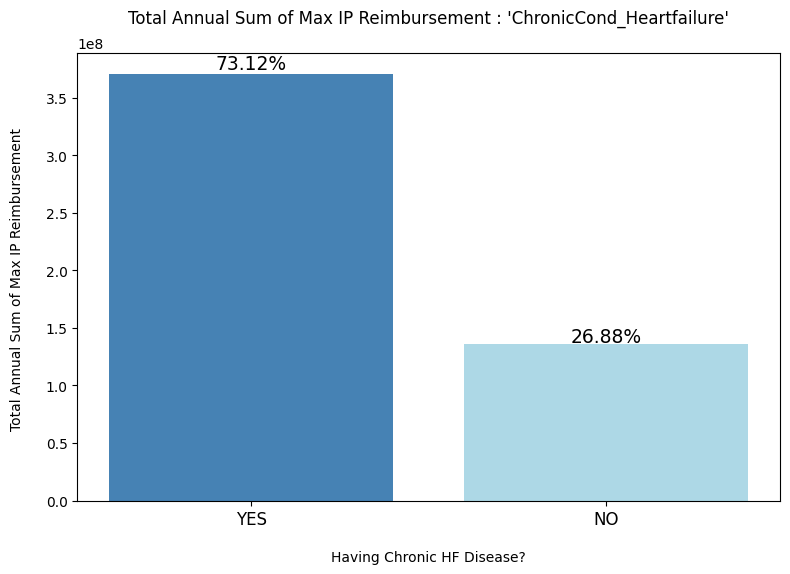

In [46]:
hf_ip_reimb = (
    train_beneficiary
    .group_by("ChronicCond_Heartfailure")
    .agg(pl.sum("IPAnnualReimbursementAmt").alias("total_ip_reimb"))
    .sort("ChronicCond_Heartfailure")
)

values = hf_ip_reimb["total_ip_reimb"].to_list()
labels_raw = hf_ip_reimb["ChronicCond_Heartfailure"].to_list()
labels = ["YES" if val == 1 else "NO" for val in labels_raw]

plt.figure(figsize=(8, 6))
bars = plt.bar(range(len(values)), values, color=["steelblue", "lightblue"])

total = sum(values)
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.annotate(
        f'{round((height * 100) / total, 2)}%',
        (bar.get_x() + bar.get_width() / 2, height * 1.01),
        ha='center',
        fontsize=13.5,
        rotation=0
    )

plt.xlabel("\nHaving Chronic HF Disease?")
plt.xticks(ticks=range(len(labels)), labels=labels, fontsize=12)
plt.ylabel("Total Annual Sum of Max IP Reimbursement \n")
plt.title("Total Annual Sum of Max IP Reimbursement : 'ChronicCond_Heartfailure'\n")
plt.tight_layout()
plt.show()

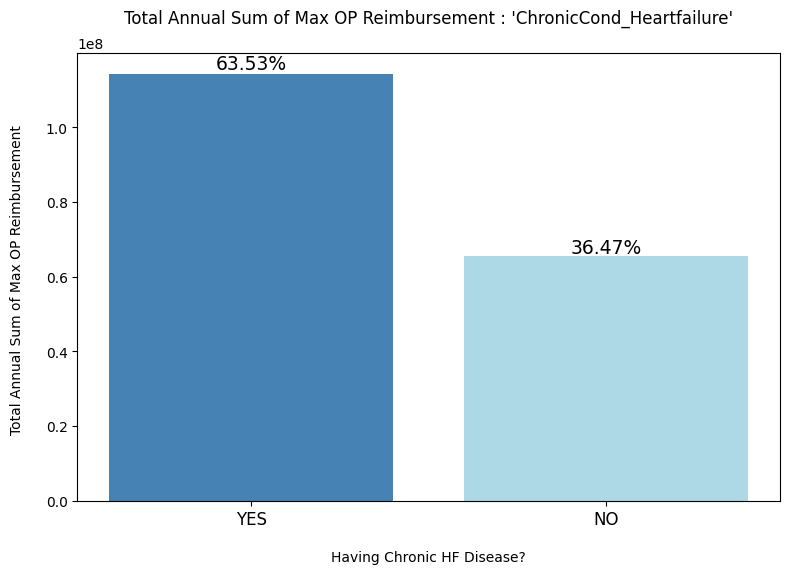

In [47]:
hf_op_reimb = (
    train_beneficiary
    .group_by("ChronicCond_Heartfailure")
    .agg(pl.sum("OPAnnualReimbursementAmt").alias("total_op_reimb"))
    .sort("ChronicCond_Heartfailure")
)

values = hf_op_reimb["total_op_reimb"].to_list()
labels_raw = hf_op_reimb["ChronicCond_Heartfailure"].to_list()
labels = ["YES" if val == 1 else "NO" for val in labels_raw]

plt.figure(figsize=(8, 6))
bars = plt.bar(range(len(values)), values, color=["steelblue", "lightblue"])

total = sum(values)
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.annotate(
        f'{round((height * 100) / total, 2)}%',
        (bar.get_x() + bar.get_width() / 2, height * 1.01),
        ha='center',
        fontsize=13.5,
        rotation=0
    )

plt.xlabel("\nHaving Chronic HF Disease?")
plt.xticks(ticks=range(len(labels)), labels=labels, fontsize=12)
plt.ylabel("Total Annual Sum of Max OP Reimbursement \n")
plt.title("Total Annual Sum of Max OP Reimbursement : 'ChronicCond_Heartfailure'\n")
plt.tight_layout()
plt.show()

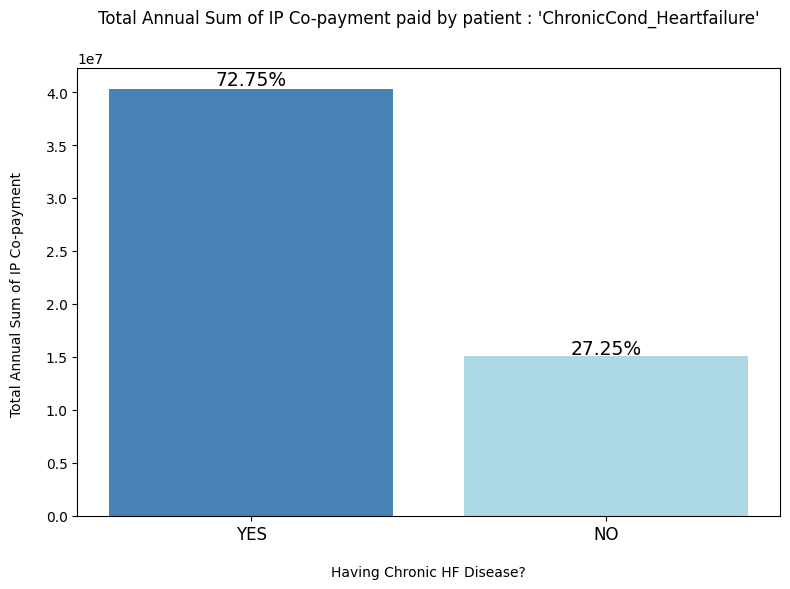

In [48]:
hf_ip_deduct = (
    train_beneficiary
    .group_by("ChronicCond_Heartfailure")
    .agg(pl.sum("IPAnnualDeductibleAmt").alias("total_ip_deduct"))
    .sort("ChronicCond_Heartfailure")
)

values = hf_ip_deduct["total_ip_deduct"].to_list()
labels_raw = hf_ip_deduct["ChronicCond_Heartfailure"].to_list()
labels = ["YES" if val == 1 else "NO" for val in labels_raw]

plt.figure(figsize=(8, 6))
bars = plt.bar(range(len(values)), values, color=["steelblue", "lightblue"])

total = sum(values)
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.annotate(
        f'{round((height * 100) / total, 2)}%',
        (bar.get_x() + bar.get_width() / 2, height * 1.01),
        ha='center',
        fontsize=13.5,
        rotation=0
    )

plt.xlabel("\nHaving Chronic HF Disease?")
plt.xticks(ticks=range(len(labels)), labels=labels, fontsize=12)
plt.ylabel("Total Annual Sum of IP Co-payment \n")
plt.title("Total Annual Sum of IP Co-payment paid by patient : 'ChronicCond_Heartfailure'\n")
plt.tight_layout()
plt.show()

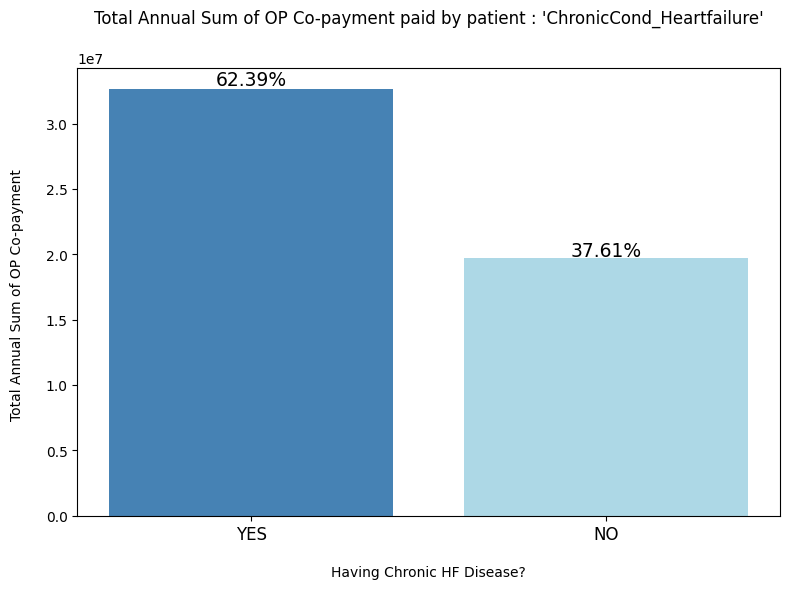

In [49]:
hf_op_deduct = (
    train_beneficiary
    .group_by("ChronicCond_Heartfailure")
    .agg(pl.sum("OPAnnualDeductibleAmt").alias("total_op_deduct"))
    .sort("ChronicCond_Heartfailure")
)

values = hf_op_deduct["total_op_deduct"].to_list()
labels_raw = hf_op_deduct["ChronicCond_Heartfailure"].to_list()
labels = ["YES" if val == 1 else "NO" for val in labels_raw]

plt.figure(figsize=(8, 6))
bars = plt.bar(range(len(values)), values, color=["steelblue", "lightblue"])

total = sum(values)
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.annotate(
        f'{round((height * 100) / total, 2)}%',
        (bar.get_x() + bar.get_width() / 2, height * 1.01),
        ha='center',
        fontsize=13.5,
        rotation=0
    )

plt.xlabel("\nHaving Chronic HF Disease?")
plt.xticks(ticks=range(len(labels)), labels=labels, fontsize=12)
plt.ylabel("Total Annual Sum of OP Co-payment \n")
plt.title("Total Annual Sum of OP Co-payment paid by patient : 'ChronicCond_Heartfailure'\n")
plt.tight_layout()
plt.show()

In [50]:
hf_counts = (
    train_beneficiary
    .group_by("ChronicCond_Heartfailure")
    .agg(pl.count("BeneID").alias("BeneCount"))
    .sort("ChronicCond_Heartfailure")
)

In [51]:
hf_counts

ChronicCond_Heartfailure,BeneCount
i64,u32
1,68402
2,70154


In [52]:
hf_sums = (
    train_beneficiary
    .group_by("ChronicCond_Heartfailure")
    .agg([
        pl.sum("IPAnnualReimbursementAmt").alias("Total_IP_Reimb"),
        pl.sum("OPAnnualReimbursementAmt").alias("Total_OP_Reimb"),
        pl.sum("IPAnnualDeductibleAmt").alias("Total_IP_Deduct"),
        pl.sum("OPAnnualDeductibleAmt").alias("Total_OP_Deduct")
    ])
    .sort("ChronicCond_Heartfailure")
)

In [53]:
hf_combined = hf_sums.join(hf_counts, on="ChronicCond_Heartfailure")

In [54]:
hf_avg = hf_combined.with_columns([
    (pl.col("Total_IP_Reimb") / pl.col("BeneCount")).alias("AVG IP Reimbursement Amt"),
    (pl.col("Total_OP_Reimb") / pl.col("BeneCount")).alias("AVG OP Reimbursement Amt"),
    (pl.col("Total_IP_Deduct") / pl.col("BeneCount")).alias("AVG IP Co-payment Amt"),
    (pl.col("Total_OP_Deduct") / pl.col("BeneCount")).alias("AVG OP Co-payment Amt")
])

In [55]:
hf_plot_df = (
    hf_avg
    .select([
        "ChronicCond_Heartfailure",
        "AVG IP Reimbursement Amt",
        "AVG OP Reimbursement Amt",
        "AVG IP Co-payment Amt",
        "AVG OP Co-payment Amt"
    ])
    .sort("ChronicCond_Heartfailure")
    .to_pandas()
    .set_index("ChronicCond_Heartfailure")
)

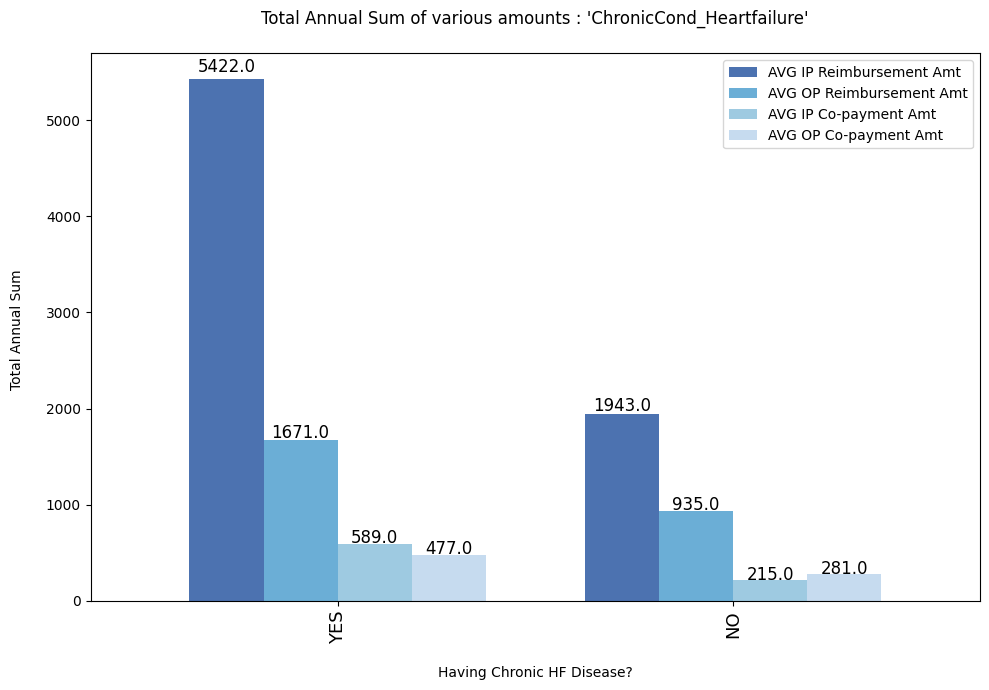

In [56]:
hf_plot_df.index = ["YES", "NO"]

fig = hf_plot_df.plot(kind='bar', color=["#4c72b0", "#6baed6", "#9ecae1", "#c6dbef"], figsize=(10, 7), width=0.75)

for bar in fig.patches:
    height = bar.get_height()
    x = bar.get_x()
    width = bar.get_width()
    fig.annotate(
        f'{round(height, 0)}',
        (x + width / 2, height * 1.015),
        ha='center',
        fontsize=12,
        rotation=0
    )


plt.xlabel("\nHaving Chronic HF Disease?")
plt.xticks(fontsize=13)
plt.ylabel("Total Annual Sum \n")
plt.title("Total Annual Sum of various amounts : 'ChronicCond_Heartfailure'\n")
plt.tight_layout()
plt.show()


In [57]:
kd_counts = (
    train_beneficiary
    .group_by("ChronicCond_KidneyDisease")
    .agg(pl.count("BeneID").alias("BeneCount"))
    .sort("ChronicCond_KidneyDisease")
)

In [58]:
kd_counts

ChronicCond_KidneyDisease,BeneCount
i64,u32
1,43279
2,95277


In [59]:
kd_sums = (
    train_beneficiary
    .group_by("ChronicCond_KidneyDisease")
    .agg([
        pl.sum("IPAnnualReimbursementAmt").alias("Total_IP_Reimb"),
        pl.sum("OPAnnualReimbursementAmt").alias("Total_OP_Reimb"),
        pl.sum("IPAnnualDeductibleAmt").alias("Total_IP_Deduct"),
        pl.sum("OPAnnualDeductibleAmt").alias("Total_OP_Deduct")
    ])
    .sort("ChronicCond_KidneyDisease")
)

In [60]:
kd_combined = kd_sums.join(kd_counts, on="ChronicCond_KidneyDisease")

kd_avg = kd_combined.with_columns([
    (pl.col("Total_IP_Reimb") / pl.col("BeneCount")).alias("AVG IP Reimbursement Amt"),
    (pl.col("Total_OP_Reimb") / pl.col("BeneCount")).alias("AVG OP Reimbursement Amt"),
    (pl.col("Total_IP_Deduct") / pl.col("BeneCount")).alias("AVG IP Co-payment Amt"),
    (pl.col("Total_OP_Deduct") / pl.col("BeneCount")).alias("AVG OP Co-payment Amt")
])

In [61]:
kd_plot_df = (
    kd_avg
    .select([
        "ChronicCond_KidneyDisease",
        "AVG IP Reimbursement Amt",
        "AVG OP Reimbursement Amt",
        "AVG IP Co-payment Amt",
        "AVG OP Co-payment Amt"
    ])
    .sort("ChronicCond_KidneyDisease")
    .to_pandas()
    .set_index("ChronicCond_KidneyDisease")
)

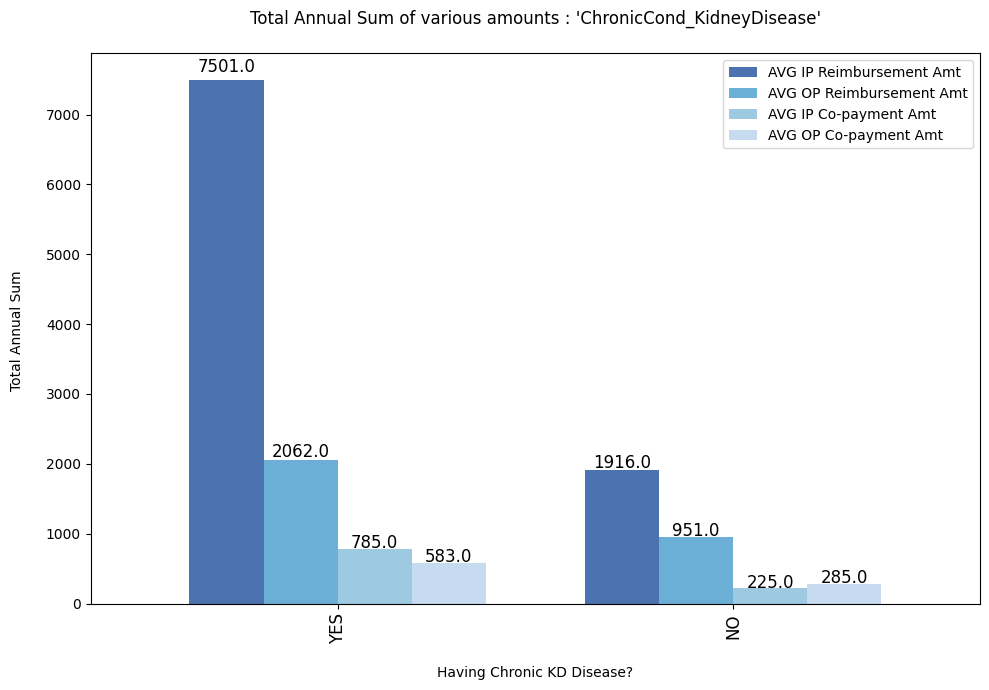

In [62]:
kd_plot_df.index = ["YES", "NO"]

fig = kd_plot_df.plot(
    kind='bar',
    color=["#4c72b0", "#6baed6", "#9ecae1", "#c6dbef"],
    figsize=(10, 7),
    width=0.75
)

for bar in fig.patches:
    height = bar.get_height()
    x = bar.get_x()
    width = bar.get_width()
    fig.annotate(
        f'{round(height, 0)}',
        (x + width / 2, height * 1.015),
        ha='center',
        fontsize=12,
        rotation=0
    )


plt.xlabel("\nHaving Chronic KD Disease?")
plt.xticks(fontsize=12)
plt.ylabel("Total Annual Sum \n")
plt.title("Total Annual Sum of various amounts : 'ChronicCond_KidneyDisease'\n")
plt.tight_layout()
plt.show()


In [63]:
cn_counts = (
    train_beneficiary
    .group_by("ChronicCond_Cancer")
    .agg(pl.count("BeneID").alias("BeneCount"))
    .sort("ChronicCond_Cancer")
)

In [64]:
cn_counts

ChronicCond_Cancer,BeneCount
i64,u32
1,16621
2,121935


In [65]:
cn_sums = (
    train_beneficiary
    .group_by("ChronicCond_Cancer")
    .agg([
        pl.sum("IPAnnualReimbursementAmt").alias("Total_IP_Reimb"),
        pl.sum("OPAnnualReimbursementAmt").alias("Total_OP_Reimb"),
        pl.sum("IPAnnualDeductibleAmt").alias("Total_IP_Deduct"),
        pl.sum("OPAnnualDeductibleAmt").alias("Total_OP_Deduct")
    ])
    .sort("ChronicCond_Cancer")
)

In [66]:
cn_combined = cn_sums.join(cn_counts, on="ChronicCond_Cancer")

cn_avg = cn_combined.with_columns([
    (pl.col("Total_IP_Reimb") / pl.col("BeneCount")).alias("AVG IP Reimbursement Amt"),
    (pl.col("Total_OP_Reimb") / pl.col("BeneCount")).alias("AVG OP Reimbursement Amt"),
    (pl.col("Total_IP_Deduct") / pl.col("BeneCount")).alias("AVG IP Co-payment Amt"),
    (pl.col("Total_OP_Deduct") / pl.col("BeneCount")).alias("AVG OP Co-payment Amt")
])

In [67]:
cn_plot_df = (
    cn_avg
    .select([
        "ChronicCond_Cancer",
        "AVG IP Reimbursement Amt",
        "AVG OP Reimbursement Amt",
        "AVG IP Co-payment Amt",
        "AVG OP Co-payment Amt"
    ])
    .sort("ChronicCond_Cancer")
    .to_pandas()
    .set_index("ChronicCond_Cancer")
)

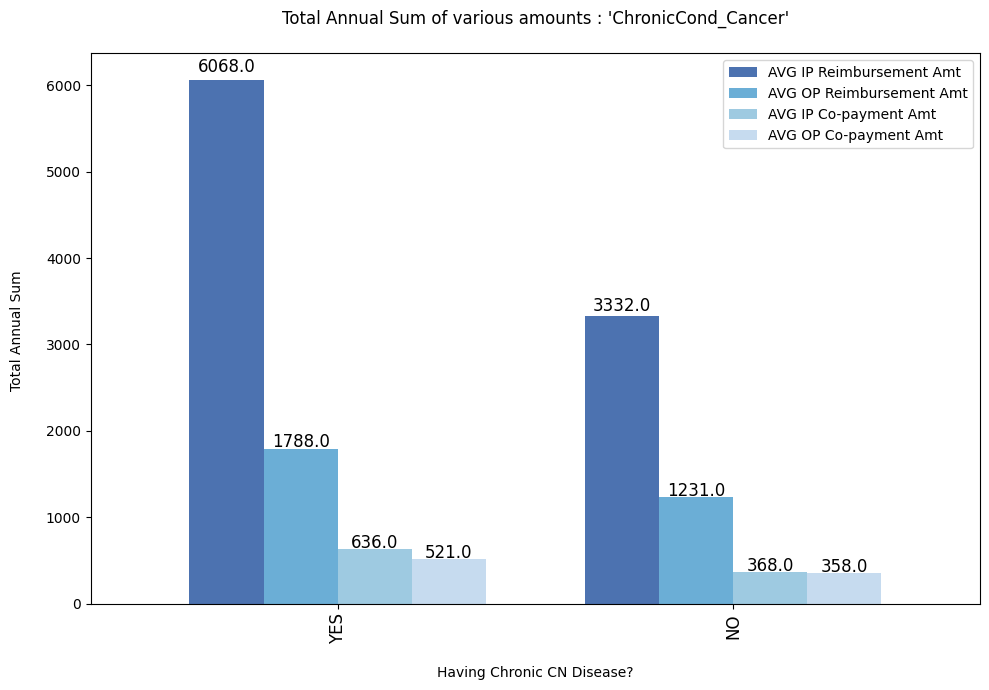

In [68]:
cn_plot_df.index = ["YES", "NO"]

fig = cn_plot_df.plot(
    kind='bar',
    color=["#4c72b0", "#6baed6", "#9ecae1", "#c6dbef"],
    figsize=(10, 7),
    width=0.75
)

for bar in fig.patches:
    height = bar.get_height()
    x = bar.get_x()
    width = bar.get_width()
    fig.annotate(
        f'{round(height, 0)}',
        (x + width / 2, height * 1.015),
        ha='center',
        fontsize=12,
        rotation=0
    )

plt.xlabel("\nHaving Chronic CN Disease?")
plt.xticks(fontsize=12)
plt.ylabel("Total Annual Sum \n")
plt.title("Total Annual Sum of various amounts : 'ChronicCond_Cancer'\n")
plt.tight_layout()
plt.show()

In [69]:
pl_counts = (
    train_beneficiary
    .group_by("ChronicCond_ObstrPulmonary")
    .agg(pl.count("BeneID").alias("BeneCount"))
    .sort("ChronicCond_ObstrPulmonary")
)

In [70]:
pl_counts

ChronicCond_ObstrPulmonary,BeneCount
i64,u32
1,32859
2,105697


In [71]:
pl_sums = (
    train_beneficiary
    .group_by("ChronicCond_ObstrPulmonary")
    .agg([
        pl.sum("IPAnnualReimbursementAmt").alias("Total_IP_Reimb"),
        pl.sum("OPAnnualReimbursementAmt").alias("Total_OP_Reimb"),
        pl.sum("IPAnnualDeductibleAmt").alias("Total_IP_Deduct"),
        pl.sum("OPAnnualDeductibleAmt").alias("Total_OP_Deduct")
    ])
    .sort("ChronicCond_ObstrPulmonary")
)

In [72]:
pl_combined = pl_sums.join(pl_counts, on="ChronicCond_ObstrPulmonary")

pl_avg = pl_combined.with_columns([
    (pl.col("Total_IP_Reimb") / pl.col("BeneCount")).alias("AVG IP Reimbursement Amt"),
    (pl.col("Total_OP_Reimb") / pl.col("BeneCount")).alias("AVG OP Reimbursement Amt"),
    (pl.col("Total_IP_Deduct") / pl.col("BeneCount")).alias("AVG IP Co-payment Amt"),
    (pl.col("Total_OP_Deduct") / pl.col("BeneCount")).alias("AVG OP Co-payment Amt")
])

In [73]:
pl_plot_df = (
    pl_avg
    .select([
        "ChronicCond_ObstrPulmonary",
        "AVG IP Reimbursement Amt",
        "AVG OP Reimbursement Amt",
        "AVG IP Co-payment Amt",
        "AVG OP Co-payment Amt"
    ])
    .sort("ChronicCond_ObstrPulmonary")
    .to_pandas()
    .set_index("ChronicCond_ObstrPulmonary")
)

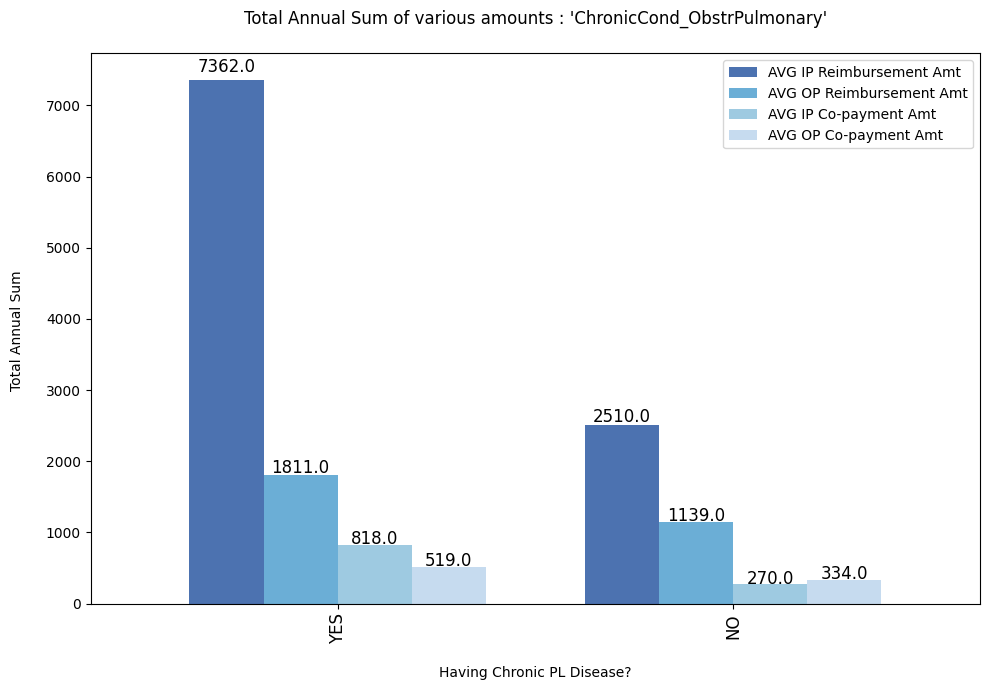

In [74]:
pl_plot_df.index = ["YES", "NO"]

fig = pl_plot_df.plot(
    kind='bar',
    color=["#4c72b0", "#6baed6", "#9ecae1", "#c6dbef"],
    figsize=(10, 7),
    width=0.75
)

for bar in fig.patches:
    height = bar.get_height()
    x = bar.get_x()
    width = bar.get_width()
    fig.annotate(
        f'{round(height, 0)}',
        (x + width / 2, height * 1.015),
        ha='center',
        fontsize=12,
        rotation=0
    )

plt.xlabel("\nHaving Chronic PL Disease?")
plt.xticks(fontsize=12)
plt.ylabel("Total Annual Sum \n")
plt.title("Total Annual Sum of various amounts : 'ChronicCond_ObstrPulmonary'\n")
plt.tight_layout()
plt.show()

In [75]:
dp_counts = (
    train_beneficiary
    .group_by("ChronicCond_Depression")
    .agg(pl.count("BeneID").alias("BeneCount"))
    .sort("ChronicCond_Depression")
)

In [76]:
dp_sums = (
    train_beneficiary
    .group_by("ChronicCond_Depression")
    .agg([
        pl.sum("IPAnnualReimbursementAmt").alias("Total_IP_Reimb"),
        pl.sum("OPAnnualReimbursementAmt").alias("Total_OP_Reimb"),
        pl.sum("IPAnnualDeductibleAmt").alias("Total_IP_Deduct"),
        pl.sum("OPAnnualDeductibleAmt").alias("Total_OP_Deduct")
    ])
    .sort("ChronicCond_Depression")
)

In [77]:
dp_combined = dp_sums.join(dp_counts, on="ChronicCond_Depression")

dp_avg = dp_combined.with_columns([
    (pl.col("Total_IP_Reimb") / pl.col("BeneCount")).alias("AVG IP Reimbursement Amt"),
    (pl.col("Total_OP_Reimb") / pl.col("BeneCount")).alias("AVG OP Reimbursement Amt"),
    (pl.col("Total_IP_Deduct") / pl.col("BeneCount")).alias("AVG IP Co-payment Amt"),
    (pl.col("Total_OP_Deduct") / pl.col("BeneCount")).alias("AVG OP Co-payment Amt")
])

In [78]:
dp_plot_df = (
    dp_avg
    .select([
        "ChronicCond_Depression",
        "AVG IP Reimbursement Amt",
        "AVG OP Reimbursement Amt",
        "AVG IP Co-payment Amt",
        "AVG OP Co-payment Amt"
    ])
    .sort("ChronicCond_Depression")
    .to_pandas()
    .set_index("ChronicCond_Depression")
)


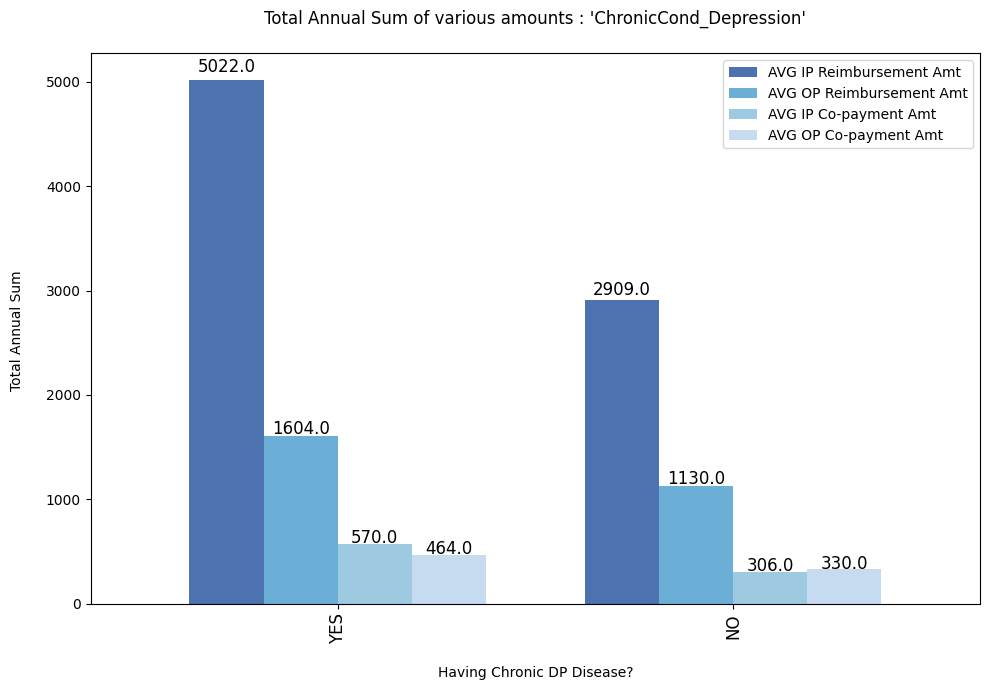

In [79]:
dp_plot_df.index = ["YES", "NO"]

fig = dp_plot_df.plot(
    kind='bar',
    color=["#4c72b0", "#6baed6", "#9ecae1", "#c6dbef"],
    figsize=(10, 7),
    width=0.75
)

for bar in fig.patches:
    height = bar.get_height()
    x = bar.get_x()
    width = bar.get_width()
    fig.annotate(
        f'{round(height, 0)}',
        (x + width / 2, height * 1.015),
        ha='center',
        fontsize=12,
        rotation=0
    )

plt.xlabel("\nHaving Chronic DP Disease?")
plt.xticks(fontsize=12)
plt.ylabel("Total Annual Sum \n")
plt.title("Total Annual Sum of various amounts : 'ChronicCond_Depression'\n")
plt.tight_layout()
plt.show()


In [80]:
db_counts = (
    train_beneficiary
    .group_by("ChronicCond_Diabetes")
    .agg(pl.count("BeneID").alias("BeneCount"))
    .sort("ChronicCond_Diabetes")
)

In [81]:
db_sums = (
    train_beneficiary
    .group_by("ChronicCond_Diabetes")
    .agg([
        pl.sum("IPAnnualReimbursementAmt").alias("Total_IP_Reimb"),
        pl.sum("OPAnnualReimbursementAmt").alias("Total_OP_Reimb"),
        pl.sum("IPAnnualDeductibleAmt").alias("Total_IP_Deduct"),
        pl.sum("OPAnnualDeductibleAmt").alias("Total_OP_Deduct")
    ])
    .sort("ChronicCond_Diabetes")
)

In [82]:
db_combined = db_sums.join(db_counts, on="ChronicCond_Diabetes")

db_avg = db_combined.with_columns([
    (pl.col("Total_IP_Reimb") / pl.col("BeneCount")).alias("AVG IP Reimbursement Amt"),
    (pl.col("Total_OP_Reimb") / pl.col("BeneCount")).alias("AVG OP Reimbursement Amt"),
    (pl.col("Total_IP_Deduct") / pl.col("BeneCount")).alias("AVG IP Co-payment Amt"),
    (pl.col("Total_OP_Deduct") / pl.col("BeneCount")).alias("AVG OP Co-payment Amt")
])

In [83]:
db_plot_df = (
    db_avg
    .select([
        "ChronicCond_Diabetes",
        "AVG IP Reimbursement Amt",
        "AVG OP Reimbursement Amt",
        "AVG IP Co-payment Amt",
        "AVG OP Co-payment Amt"
    ])
    .sort("ChronicCond_Diabetes")
    .to_pandas()
    .set_index("ChronicCond_Diabetes")
)


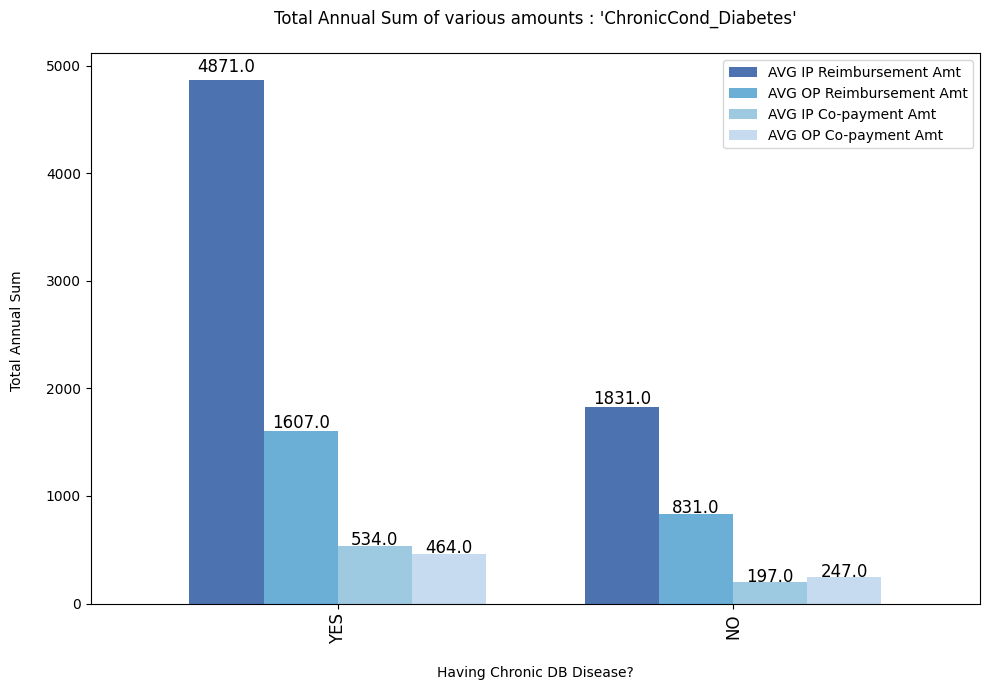

In [84]:
db_plot_df.index = ["YES", "NO"]

fig = db_plot_df.plot(
    kind='bar',
    color=["#4c72b0", "#6baed6", "#9ecae1", "#c6dbef"],
    figsize=(10, 7),
    width=0.75
)

for bar in fig.patches:
    height = bar.get_height()
    x = bar.get_x()
    width = bar.get_width()
    fig.annotate(
        f'{round(height, 0)}',
        (x + width / 2, height * 1.015),
        ha='center',
        fontsize=12,
        rotation=0
    )

plt.xlabel("\nHaving Chronic DB Disease?")
plt.xticks(fontsize=12)
plt.ylabel("Total Annual Sum \n")
plt.title("Total Annual Sum of various amounts : 'ChronicCond_Diabetes'\n")
plt.tight_layout()
plt.show()


In [85]:
ih_counts = (
    train_beneficiary
    .group_by("ChronicCond_IschemicHeart")
    .agg(pl.count("BeneID").alias("BeneCount"))
    .sort("ChronicCond_IschemicHeart")
)


In [86]:
ih_sums = (
    train_beneficiary
    .group_by("ChronicCond_IschemicHeart")
    .agg([
        pl.sum("IPAnnualReimbursementAmt").alias("Total_IP_Reimb"),
        pl.sum("OPAnnualReimbursementAmt").alias("Total_OP_Reimb"),
        pl.sum("IPAnnualDeductibleAmt").alias("Total_IP_Deduct"),
        pl.sum("OPAnnualDeductibleAmt").alias("Total_OP_Deduct")
    ])
    .sort("ChronicCond_IschemicHeart")
)

In [87]:
ih_combined = ih_sums.join(ih_counts, on="ChronicCond_IschemicHeart")

ih_avg = ih_combined.with_columns([
    (pl.col("Total_IP_Reimb") / pl.col("BeneCount")).alias("AVG IP Reimbursement Amt"),
    (pl.col("Total_OP_Reimb") / pl.col("BeneCount")).alias("AVG OP Reimbursement Amt"),
    (pl.col("Total_IP_Deduct") / pl.col("BeneCount")).alias("AVG IP Co-payment Amt"),
    (pl.col("Total_OP_Deduct") / pl.col("BeneCount")).alias("AVG OP Co-payment Amt")
])

In [88]:
ih_plot_df = (
    ih_avg
    .select([
        "ChronicCond_IschemicHeart",
        "AVG IP Reimbursement Amt",
        "AVG OP Reimbursement Amt",
        "AVG IP Co-payment Amt",
        "AVG OP Co-payment Amt"
    ])
    .sort("ChronicCond_IschemicHeart")
    .to_pandas()
    .set_index("ChronicCond_IschemicHeart")
)


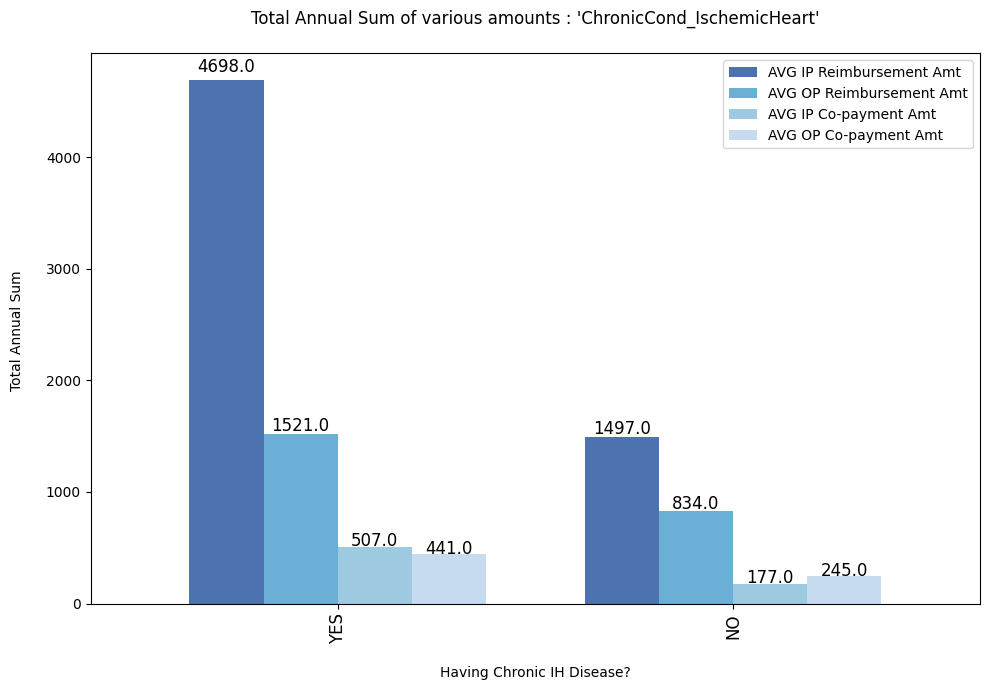

In [89]:
ih_plot_df.index = ["YES", "NO"]

fig = ih_plot_df.plot(
    kind='bar',
    color=["#4c72b0", "#6baed6", "#9ecae1", "#c6dbef"],
    figsize=(10, 7),
    width=0.75
)

for bar in fig.patches:
    height = bar.get_height()
    x = bar.get_x()
    width = bar.get_width()
    fig.annotate(
        f'{round(height, 0)}',
        (x + width / 2, height * 1.015),
        ha='center',
        fontsize=12,
        rotation=0
    )


plt.xlabel("\nHaving Chronic IH Disease?")
plt.xticks(fontsize=12)
plt.ylabel("Total Annual Sum \n")
plt.title("Total Annual Sum of various amounts : 'ChronicCond_IschemicHeart'\n")
plt.tight_layout()
plt.show()

In [90]:
os_counts = (
    train_beneficiary
    .group_by("ChronicCond_Osteoporasis")
    .agg(pl.count("BeneID").alias("BeneCount"))
    .sort("ChronicCond_Osteoporasis")
)


In [91]:
os_sums = (
    train_beneficiary
    .group_by("ChronicCond_Osteoporasis")
    .agg([
        pl.sum("IPAnnualReimbursementAmt").alias("Total_IP_Reimb"),
        pl.sum("OPAnnualReimbursementAmt").alias("Total_OP_Reimb"),
        pl.sum("IPAnnualDeductibleAmt").alias("Total_IP_Deduct"),
        pl.sum("OPAnnualDeductibleAmt").alias("Total_OP_Deduct")
    ])
    .sort("ChronicCond_Osteoporasis")
)

In [92]:
os_combined = os_sums.join(os_counts, on="ChronicCond_Osteoporasis")

os_avg = os_combined.with_columns([
    (pl.col("Total_IP_Reimb") / pl.col("BeneCount")).alias("AVG IP Reimbursement Amt"),
    (pl.col("Total_OP_Reimb") / pl.col("BeneCount")).alias("AVG OP Reimbursement Amt"),
    (pl.col("Total_IP_Deduct") / pl.col("BeneCount")).alias("AVG IP Co-payment Amt"),
    (pl.col("Total_OP_Deduct") / pl.col("BeneCount")).alias("AVG OP Co-payment Amt")
])

In [93]:
os_plot_df = (
    os_avg
    .select([
        "ChronicCond_Osteoporasis",
        "AVG IP Reimbursement Amt",
        "AVG OP Reimbursement Amt",
        "AVG IP Co-payment Amt",
        "AVG OP Co-payment Amt"
    ])
    .sort("ChronicCond_Osteoporasis")
    .to_pandas()
    .set_index("ChronicCond_Osteoporasis")
)

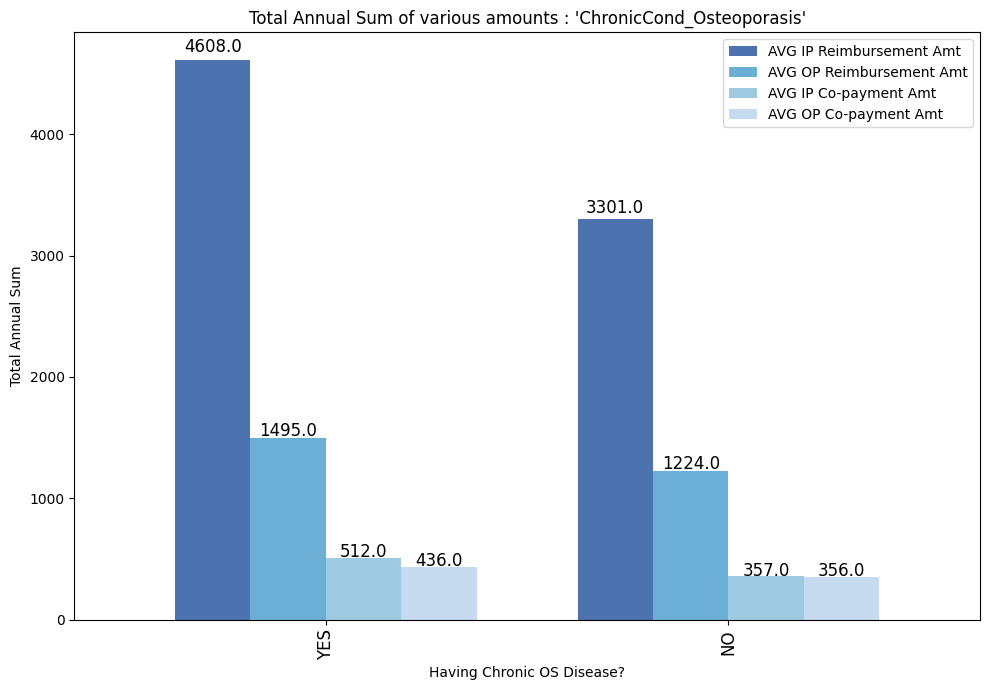

In [94]:
os_plot_df.index = ["YES", "NO"]

fig = os_plot_df.plot(
    kind='bar',
    color=["#4c72b0", "#6baed6", "#9ecae1", "#c6dbef"],
    figsize=(10, 7),
    width=0.75
)

for bar in fig.patches:
    height = bar.get_height()
    x = bar.get_x()
    width = bar.get_width()
    fig.annotate(
        f'{round(height, 0)}',
        (x + width / 2, height * 1.015),
        ha='center',
        fontsize=12,
        rotation=0
    )

plt.xlabel("Having Chronic OS Disease?")
plt.xticks(fontsize=12)
plt.ylabel("Total Annual Sum")
plt.title("Total Annual Sum of various amounts : 'ChronicCond_Osteoporasis'")
plt.tight_layout()
plt.show()

In [95]:
rh_counts = (
    train_beneficiary
    .group_by("ChronicCond_rheumatoidarthritis")
    .agg(pl.count("BeneID").alias("BeneCount"))
    .sort("ChronicCond_rheumatoidarthritis")
)

In [96]:
rh_sums = (
    train_beneficiary
    .group_by("ChronicCond_rheumatoidarthritis")
    .agg([
        pl.sum("IPAnnualReimbursementAmt").alias("Total_IP_Reimb"),
        pl.sum("OPAnnualReimbursementAmt").alias("Total_OP_Reimb"),
        pl.sum("IPAnnualDeductibleAmt").alias("Total_IP_Deduct"),
        pl.sum("OPAnnualDeductibleAmt").alias("Total_OP_Deduct")
    ])
    .sort("ChronicCond_rheumatoidarthritis")
)

In [97]:
rh_combined = rh_sums.join(rh_counts, on="ChronicCond_rheumatoidarthritis")

rh_avg = rh_combined.with_columns([
    (pl.col("Total_IP_Reimb") / pl.col("BeneCount")).alias("AVG IP Reimbursement Amt"),
    (pl.col("Total_OP_Reimb") / pl.col("BeneCount")).alias("AVG OP Reimbursement Amt"),
    (pl.col("Total_IP_Deduct") / pl.col("BeneCount")).alias("AVG IP Co-payment Amt"),
    (pl.col("Total_OP_Deduct") / pl.col("BeneCount")).alias("AVG OP Co-payment Amt")
])

In [98]:
rh_plot_df = (
    rh_avg
    .select([
        "ChronicCond_rheumatoidarthritis",
        "AVG IP Reimbursement Amt",
        "AVG OP Reimbursement Amt",
        "AVG IP Co-payment Amt",
        "AVG OP Co-payment Amt"
    ])
    .sort("ChronicCond_rheumatoidarthritis")
    .to_pandas()
    .set_index("ChronicCond_rheumatoidarthritis")
)

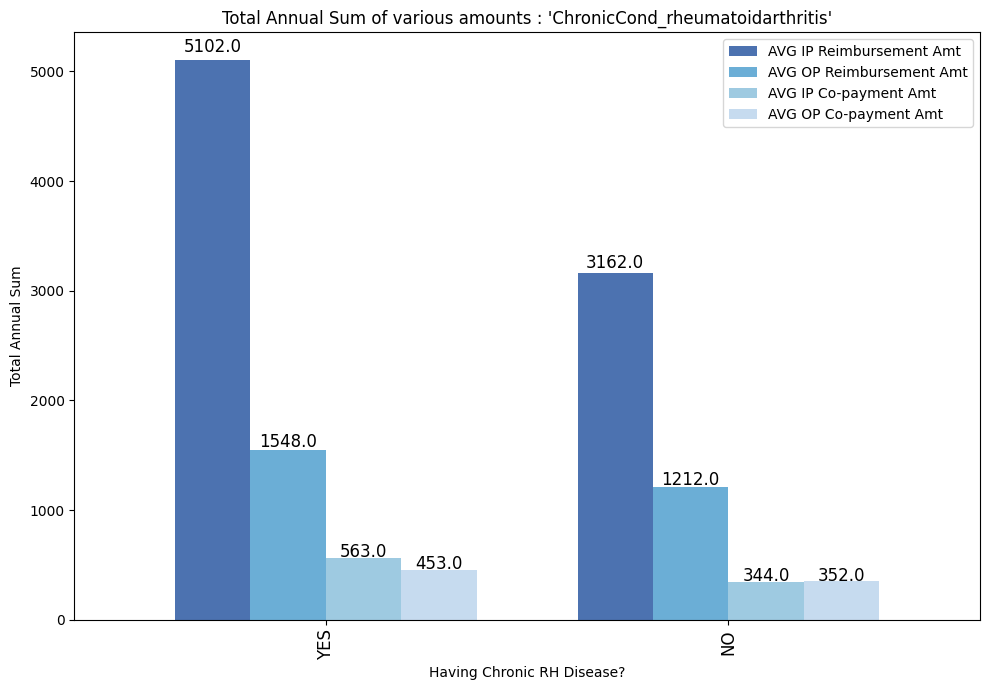

In [99]:
rh_plot_df.index = ["YES", "NO"]

fig = rh_plot_df.plot(
    kind='bar',
    color=["#4c72b0", "#6baed6", "#9ecae1", "#c6dbef"],
    figsize=(10, 7),
    width=0.75
)

for bar in fig.patches:
    height = bar.get_height()
    x = bar.get_x()
    width = bar.get_width()
    fig.annotate(
        f'{round(height, 0)}',
        (x + width / 2, height * 1.015),
        ha='center',
        fontsize=12,
        rotation=0
    )

plt.xlabel("Having Chronic RH Disease?")
plt.xticks(fontsize=12)
plt.ylabel("Total Annual Sum")
plt.title("Total Annual Sum of various amounts : 'ChronicCond_rheumatoidarthritis'")
plt.tight_layout()
plt.show()

In [100]:
st_counts = (
    train_beneficiary
    .group_by("ChronicCond_stroke")
    .agg(pl.count("BeneID").alias("BeneCount"))
    .sort("ChronicCond_stroke")
)


In [101]:
st_sums = (
    train_beneficiary
    .group_by("ChronicCond_stroke")
    .agg([
        pl.sum("IPAnnualReimbursementAmt").alias("Total_IP_Reimb"),
        pl.sum("OPAnnualReimbursementAmt").alias("Total_OP_Reimb"),
        pl.sum("IPAnnualDeductibleAmt").alias("Total_IP_Deduct"),
        pl.sum("OPAnnualDeductibleAmt").alias("Total_OP_Deduct")
    ])
    .sort("ChronicCond_stroke")
)

In [102]:
st_combined = st_sums.join(st_counts, on="ChronicCond_stroke")

st_avg = st_combined.with_columns([
    (pl.col("Total_IP_Reimb") / pl.col("BeneCount")).alias("AVG IP Reimbursement Amt"),
    (pl.col("Total_OP_Reimb") / pl.col("BeneCount")).alias("AVG OP Reimbursement Amt"),
    (pl.col("Total_IP_Deduct") / pl.col("BeneCount")).alias("AVG IP Co-payment Amt"),
    (pl.col("Total_OP_Deduct") / pl.col("BeneCount")).alias("AVG OP Co-payment Amt")
])

In [103]:
st_plot_df = (
    st_avg
    .select([
        "ChronicCond_stroke",
        "AVG IP Reimbursement Amt",
        "AVG OP Reimbursement Amt",
        "AVG IP Co-payment Amt",
        "AVG OP Co-payment Amt"
    ])
    .sort("ChronicCond_stroke")
    .to_pandas()
    .set_index("ChronicCond_stroke")
)

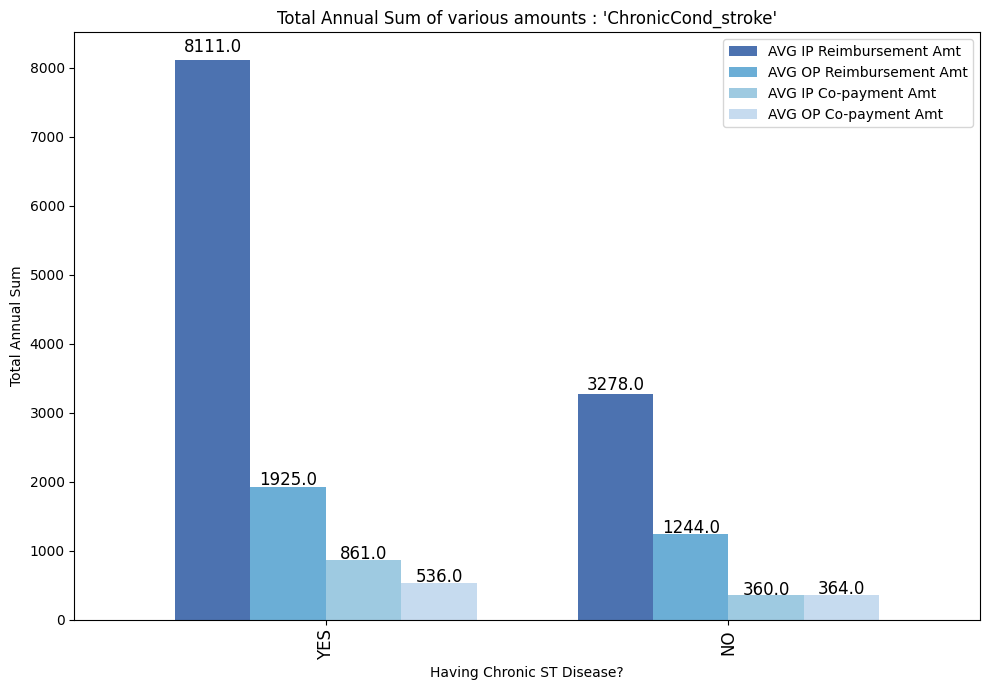

In [104]:
st_plot_df.index = ["YES", "NO"]

fig = st_plot_df.plot(
    kind='bar',
    color=["#4c72b0", "#6baed6", "#9ecae1", "#c6dbef"],
    figsize=(10, 7),
    width=0.75
)

for bar in fig.patches:
    height = bar.get_height()
    x = bar.get_x()
    width = bar.get_width()
    fig.annotate(
        f'{round(height, 0)}',
        (x + width / 2, height * 1.015),
        ha='center',
        fontsize=12,
        rotation=0
    )

plt.xlabel("Having Chronic ST Disease?")
plt.xticks(fontsize=12)
plt.ylabel("Total Annual Sum")
plt.title("Total Annual Sum of various amounts : 'ChronicCond_stroke'")
plt.tight_layout()
plt.show()


In [105]:
rkd_counts = (
    train_beneficiary
    .group_by("RenalDiseaseIndicator")
    .agg(pl.count("BeneID").alias("BeneCount"))
    .sort("RenalDiseaseIndicator")
)

In [106]:
rkd_sums = (
    train_beneficiary
    .group_by("RenalDiseaseIndicator")
    .agg([
        pl.sum("IPAnnualReimbursementAmt").alias("Total_IP_Reimb"),
        pl.sum("OPAnnualReimbursementAmt").alias("Total_OP_Reimb"),
        pl.sum("IPAnnualDeductibleAmt").alias("Total_IP_Deduct"),
        pl.sum("OPAnnualDeductibleAmt").alias("Total_OP_Deduct")
    ])
    .sort("RenalDiseaseIndicator")
)


In [107]:
rkd_combined = rkd_sums.join(rkd_counts, on="RenalDiseaseIndicator")

rkd_avg = rkd_combined.with_columns([
    (pl.col("Total_IP_Reimb") / pl.col("BeneCount")).alias("AVG IP Reimbursement Amt"),
    (pl.col("Total_OP_Reimb") / pl.col("BeneCount")).alias("AVG OP Reimbursement Amt"),
    (pl.col("Total_IP_Deduct") / pl.col("BeneCount")).alias("AVG IP Co-payment Amt"),
    (pl.col("Total_OP_Deduct") / pl.col("BeneCount")).alias("AVG OP Co-payment Amt")
])


In [108]:
rkd_plot_df = (
    rkd_avg
    .select([
        "RenalDiseaseIndicator",
        "AVG IP Reimbursement Amt",
        "AVG OP Reimbursement Amt",
        "AVG IP Co-payment Amt",
        "AVG OP Co-payment Amt"
    ])
    .sort("RenalDiseaseIndicator")
    .to_pandas()
    .set_index("RenalDiseaseIndicator")
)


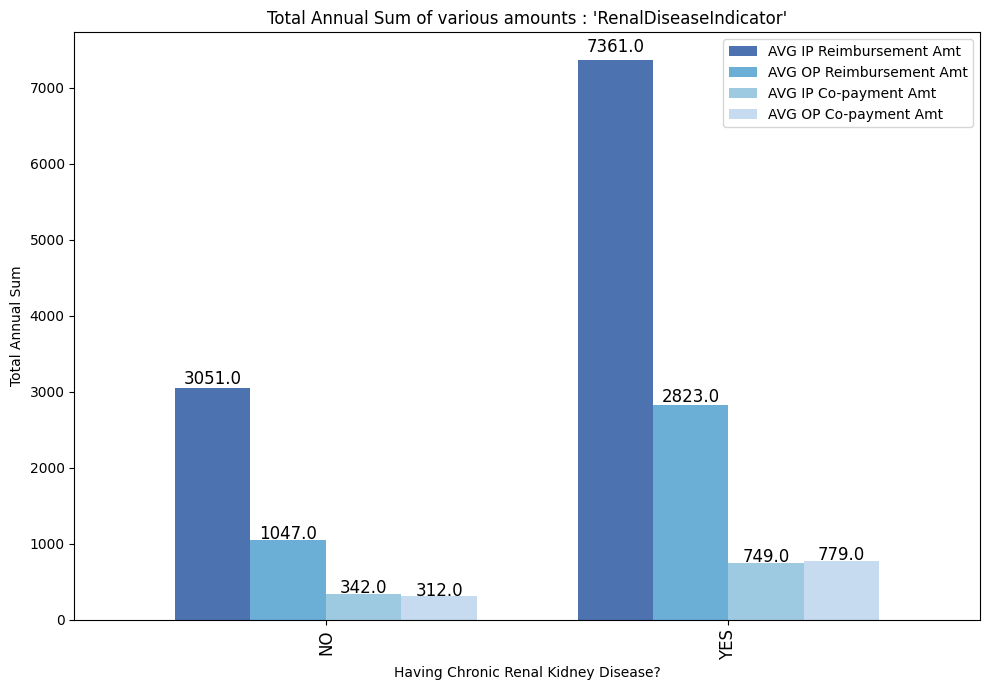

In [109]:
rkd_plot_df.index = ["NO", "YES"]

fig = rkd_plot_df.plot(
    kind='bar',
    color=["#4c72b0", "#6baed6", "#9ecae1", "#c6dbef"],
    figsize=(10, 7),
    width=0.75
)

for bar in fig.patches:
    height = bar.get_height()
    x = bar.get_x()
    width = bar.get_width()
    fig.annotate(
        f'{round(height, 0)}',
        (x + width / 2, height * 1.015),
        ha='center',
        fontsize=12,
        rotation=0
    )

plt.xlabel("Having Chronic Renal Kidney Disease?")
plt.xticks(fontsize=12)
plt.ylabel("Total Annual Sum")
plt.title("Total Annual Sum of various amounts : 'RenalDiseaseIndicator'")
plt.tight_layout()
plt.show()

### Summary

The following features from the BENE dataset exhibit minimal variability across records, suggesting limited analytical value. As such, they will be removed:

`NoOfMonths_PartACov`

`NoOfMonths_PartBCov`

`Date of Death`

In [110]:
train_beneficiary = train_beneficiary.drop(["NoOfMonths_PartACov", "NoOfMonths_PartBCov", "DOD"])

print(train_beneficiary.shape)

(138556, 27)


In [111]:
train_beneficiary.head()

BeneID,DOB,Gender,Race,RenalDiseaseIndicator,State,County,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Patient_Age_Year,Patient_Age_Month,Dead_or_Alive,AGE,AGE_groups
str,date,i64,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i32,i8,i32,f64,str
"""BENE11001""",1943-01-01,1,1,"""0""",39,230,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70,1943,1,0,67.0,"""Old"""
"""BENE11002""",1936-09-01,2,1,"""0""",39,280,2,2,2,2,2,2,2,2,2,2,2,0,0,30,50,1936,9,0,73.3,"""Old"""
"""BENE11003""",1936-08-01,1,1,"""0""",52,590,1,2,2,2,2,2,2,1,2,2,2,0,0,90,40,1936,8,0,73.4,"""Old"""
"""BENE11004""",1922-07-01,1,1,"""0""",39,270,1,1,2,2,2,2,1,1,1,1,2,0,0,1810,760,1922,7,0,87.5,"""Very Old"""
"""BENE11005""",1935-09-01,1,1,"""0""",24,680,2,2,2,2,1,2,1,2,2,2,2,0,0,1790,1200,1935,9,0,74.3,"""Old"""


## Exploring In-patients and Out-patients Data

In [112]:
print(f"Shape of Training InPatient Data: {train_inpatient.shape}")
print(f"Shape of Training OutPatient Data: {train_outpatient.shape}")
print(f"="*50)
print(f"Shape of Testing InPatient Data: {test_inpatient.shape}")
print(f"Shape of Testing OutPatient Data: {test_outpatient.shape}")

Shape of Training InPatient Data: (40474, 30)
Shape of Training OutPatient Data: (517737, 27)
Shape of Testing InPatient Data: (9551, 30)
Shape of Testing OutPatient Data: (125841, 27)


In [113]:
print(f"Columns in InPatient Data: {train_inpatient.columns}")

Columns in InPatient Data: ['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider', 'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician', 'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode', 'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5', 'ClmProcedureCode_6']


In [114]:
print(f"Columns in OutPatient Data: {train_outpatient.columns}")

Columns in OutPatient Data: ['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider', 'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician', 'OtherPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5', 'ClmProcedureCode_6', 'DeductibleAmtPaid', 'ClmAdmitDiagnosisCode']


In [115]:
train_inpatient.schema

Schema([('BeneID', String),
        ('ClaimID', String),
        ('ClaimStartDt', String),
        ('ClaimEndDt', String),
        ('Provider', String),
        ('InscClaimAmtReimbursed', Int64),
        ('AttendingPhysician', String),
        ('OperatingPhysician', String),
        ('OtherPhysician', String),
        ('AdmissionDt', String),
        ('ClmAdmitDiagnosisCode', String),
        ('DeductibleAmtPaid', String),
        ('DischargeDt', String),
        ('DiagnosisGroupCode', Int64),
        ('ClmDiagnosisCode_1', Int64),
        ('ClmDiagnosisCode_2', String),
        ('ClmDiagnosisCode_3', String),
        ('ClmDiagnosisCode_4', String),
        ('ClmDiagnosisCode_5', String),
        ('ClmDiagnosisCode_6', String),
        ('ClmDiagnosisCode_7', String),
        ('ClmDiagnosisCode_8', String),
        ('ClmDiagnosisCode_9', String),
        ('ClmDiagnosisCode_10', String),
        ('ClmProcedureCode_1', String),
        ('ClmProcedureCode_2', String),
        ('ClmProcedur

In [116]:
train_outpatient.schema

Schema([('BeneID', String),
        ('ClaimID', String),
        ('ClaimStartDt', String),
        ('ClaimEndDt', String),
        ('Provider', String),
        ('InscClaimAmtReimbursed', Int64),
        ('AttendingPhysician', String),
        ('OperatingPhysician', String),
        ('OtherPhysician', String),
        ('ClmDiagnosisCode_1', String),
        ('ClmDiagnosisCode_2', String),
        ('ClmDiagnosisCode_3', String),
        ('ClmDiagnosisCode_4', String),
        ('ClmDiagnosisCode_5', String),
        ('ClmDiagnosisCode_6', String),
        ('ClmDiagnosisCode_7', String),
        ('ClmDiagnosisCode_8', String),
        ('ClmDiagnosisCode_9', String),
        ('ClmDiagnosisCode_10', String),
        ('ClmProcedureCode_1', String),
        ('ClmProcedureCode_2', String),
        ('ClmProcedureCode_3', String),
        ('ClmProcedureCode_4', String),
        ('ClmProcedureCode_5', String),
        ('ClmProcedureCode_6', String),
        ('DeductibleAmtPaid', Int64),
        (

In [117]:
inpatient_stats = get_stats(train_inpatient)

In [118]:
inpatient_stats

Columns,Data Type,Non-Null count,Null count,Missing Percentage (%),Number of Unique Values,Sample Unique Values,Kurtosis,Skewness
str,object,i64,i64,f64,i64,list[str],f64,f64
"""BeneID""",String,40474,0,0.0,31289,"[""BENE142394"", ""BENE102317"", … ""BENE151135""]",null,null
"""ClaimID""",String,40474,0,0.0,40474,"[""CLM66629"", ""CLM49333"", … ""CLM74693""]",null,null
"""ClaimStartDt""",String,40474,0,0.0,398,"[""2009-11-30"", ""2009-06-17"", … ""2009-09-13""]",null,null
"""ClaimEndDt""",String,40474,0,0.0,365,"[""2009-12-20"", ""2009-10-19"", … ""2009-10-10""]",null,null
"""Provider""",String,40474,0,0.0,2092,"[""PRV52292"", ""PRV51947"", … ""PRV51428""]",null,null
…,…,…,…,…,…,…,…,…
"""ClmProcedureCode_2""",String,5454,35020,86.524683,298,"[""2181"", ""2769"", … ""1173""]",null,null
"""ClmProcedureCode_3""",String,965,39509,97.615753,155,"[""2763"", ""3129"", … ""2811""]",null,null
"""ClmProcedureCode_4""",String,116,40358,99.713396,49,"[""7802"", ""2749"", … ""4439""]",null,null


In [119]:
ip_has_nulls = inpatient_stats.filter(pl.col("Null count") > 0)

print("Columns with null values:")
print(
    ip_has_nulls
    .sort("Null count", descending=True)
    .select(["Columns", "Null count", "Missing Percentage (%)"])
)

Columns with null values:
shape: (21, 3)
┌─────────────────────┬────────────┬────────────────────────┐
│ Columns             ┆ Null count ┆ Missing Percentage (%) │
│ ---                 ┆ ---        ┆ ---                    │
│ str                 ┆ i64        ┆ f64                    │
╞═════════════════════╪════════════╪════════════════════════╡
│ ClmProcedureCode_6  ┆ 40474      ┆ 100.0                  │
│ ClmProcedureCode_5  ┆ 40465      ┆ 99.977764              │
│ ClmProcedureCode_4  ┆ 40358      ┆ 99.713396              │
│ ClmProcedureCode_3  ┆ 39509      ┆ 97.615753              │
│ ClmDiagnosisCode_10 ┆ 36547      ┆ 90.297475              │
│ …                   ┆ …          ┆ …                      │
│ DeductibleAmtPaid   ┆ 899        ┆ 2.221179               │
│ ClmDiagnosisCode_3  ┆ 676        ┆ 1.670208               │
│ ClmDiagnosisCode_2  ┆ 226        ┆ 0.558383               │
│ DiagnosisGroupCode  ┆ 113        ┆ 0.279192               │
│ AttendingPhysician  ┆ 112  

In [120]:
outpatient_stats = get_stats(train_outpatient)

In [121]:
outpatient_stats

Columns,Data Type,Non-Null count,Null count,Missing Percentage (%),Number of Unique Values,Sample Unique Values,Kurtosis,Skewness
str,object,i64,i64,f64,i64,list[str],f64,f64
"""BeneID""",String,517737,0,0.0,133980,"[""BENE98094"", ""BENE22682"", … ""BENE44884""]",null,null
"""ClaimID""",String,517737,0,0.0,517737,"[""CLM226199"", ""CLM478902"", … ""CLM423721""]",null,null
"""ClaimStartDt""",String,517737,0,0.0,385,"[""2009-12-05"", ""2009-07-18"", … ""2009-05-15""]",null,null
"""ClaimEndDt""",String,517737,0,0.0,366,"[""2009-10-03"", ""2009-05-05"", … ""2009-12-02""]",null,null
"""Provider""",String,517737,0,0.0,5012,"[""PRV53020"", ""PRV54449"", … ""PRV55118""]",null,null
…,…,…,…,…,…,…,…,…
"""ClmProcedureCode_4""",String,2,517735,99.999614,3,"[""311"", null, ""7840""]",null,null
"""ClmProcedureCode_5""",String,0,517737,100.0,1,[null],null,null
"""ClmProcedureCode_6""",String,0,517737,100.0,1,[null],null,null


In [122]:
op_has_nulls = outpatient_stats.filter(pl.col("Null count") > 0)

print("Columns with null values:")
print(
    op_has_nulls
    .sort("Null count", descending=True)
    .select(["Columns", "Null count", "Missing Percentage (%)"])
)

Columns with null values:
shape: (19, 3)
┌────────────────────┬────────────┬────────────────────────┐
│ Columns            ┆ Null count ┆ Missing Percentage (%) │
│ ---                ┆ ---        ┆ ---                    │
│ str                ┆ i64        ┆ f64                    │
╞════════════════════╪════════════╪════════════════════════╡
│ ClmProcedureCode_5 ┆ 517737     ┆ 100.0                  │
│ ClmProcedureCode_6 ┆ 517737     ┆ 100.0                  │
│ ClmProcedureCode_4 ┆ 517735     ┆ 99.999614              │
│ ClmProcedureCode_3 ┆ 517733     ┆ 99.999227              │
│ ClmProcedureCode_2 ┆ 517701     ┆ 99.993047              │
│ …                  ┆ …          ┆ …                      │
│ OtherPhysician     ┆ 322691     ┆ 62.327205              │
│ ClmDiagnosisCode_3 ┆ 314480     ┆ 60.741264              │
│ ClmDiagnosisCode_2 ┆ 195380     ┆ 37.737307              │
│ ClmDiagnosisCode_1 ┆ 10453      ┆ 2.018979               │
│ AttendingPhysician ┆ 1396       ┆ 0.269635

In [123]:
# Patient IDs who medicated with or without admission
ip_bene_unq = set(train_inpatient.select("BeneID").unique().to_series())
op_bene_unq = set(train_outpatient.select("BeneID").unique().to_series())

print(f"Inpatient patients: {len(ip_bene_unq)}, Outpatient patients: {len(op_bene_unq)}")

# Patient IDs who medicated with admission
only_in_patients = ip_bene_unq.intersection(op_bene_unq)
only_out_patients = op_bene_unq.difference(ip_bene_unq)

print(f"Only inpatient patients: {len(only_in_patients)}, Only outpatient patients: {len(only_out_patients)}")

tot_patients = len(only_in_patients) + len(only_out_patients)
print(f"Total patients: {tot_patients}")

Inpatient patients: 31289, Outpatient patients: 133980
Only inpatient patients: 26713, Only outpatient patients: 107267
Total patients: 133980


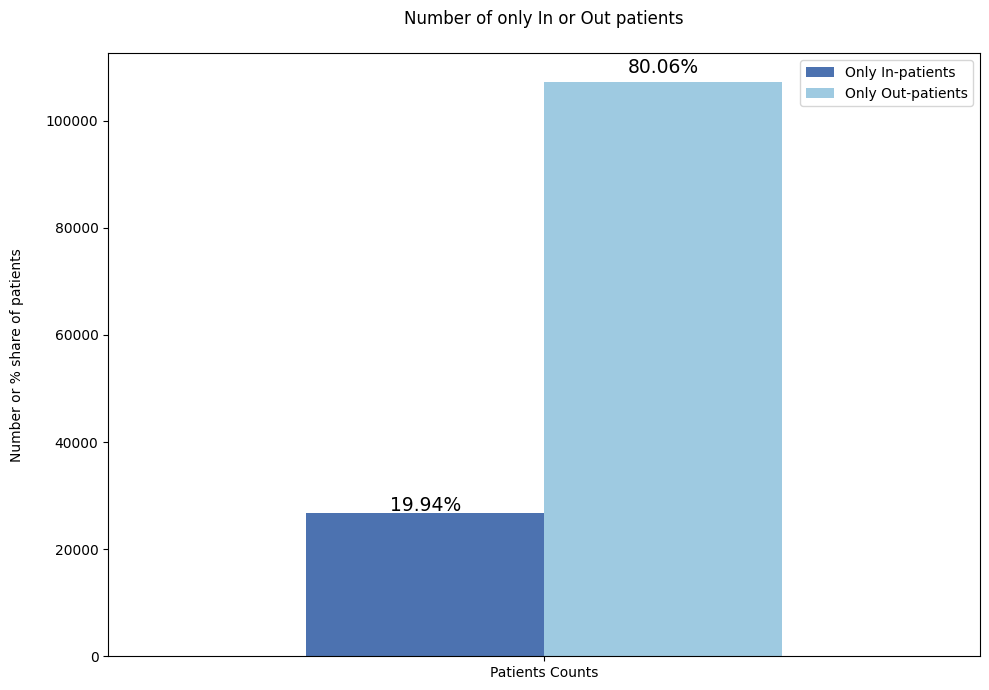

In [124]:
patients_counts = pl.DataFrame({
    "Only In-patients": [len(only_in_patients)],
    "Only Out-patients": [len(only_out_patients)]
}).to_pandas()


fig = patients_counts.plot(
    kind='bar',
    color=["#4c72b0", "#9ecae1"],
    figsize=(10, 7),
    width=0.6
)

for p in fig.patches:
    height = p.get_height()
    x = p.get_x()
    width = p.get_width()
    fig.annotate(
        f'{round((height * 100) / tot_patients, 2)}%',
        (x + width / 2, height * 1.015),
        ha='center',
        fontsize=13.5
    )

plt.xticks(labels=["Patients Counts"], ticks=[0], rotation=0)
plt.ylabel("Number or % share of patients\n")
plt.title("Number of only In or Out patients\n")
plt.tight_layout()
plt.show()


### In-patients Data

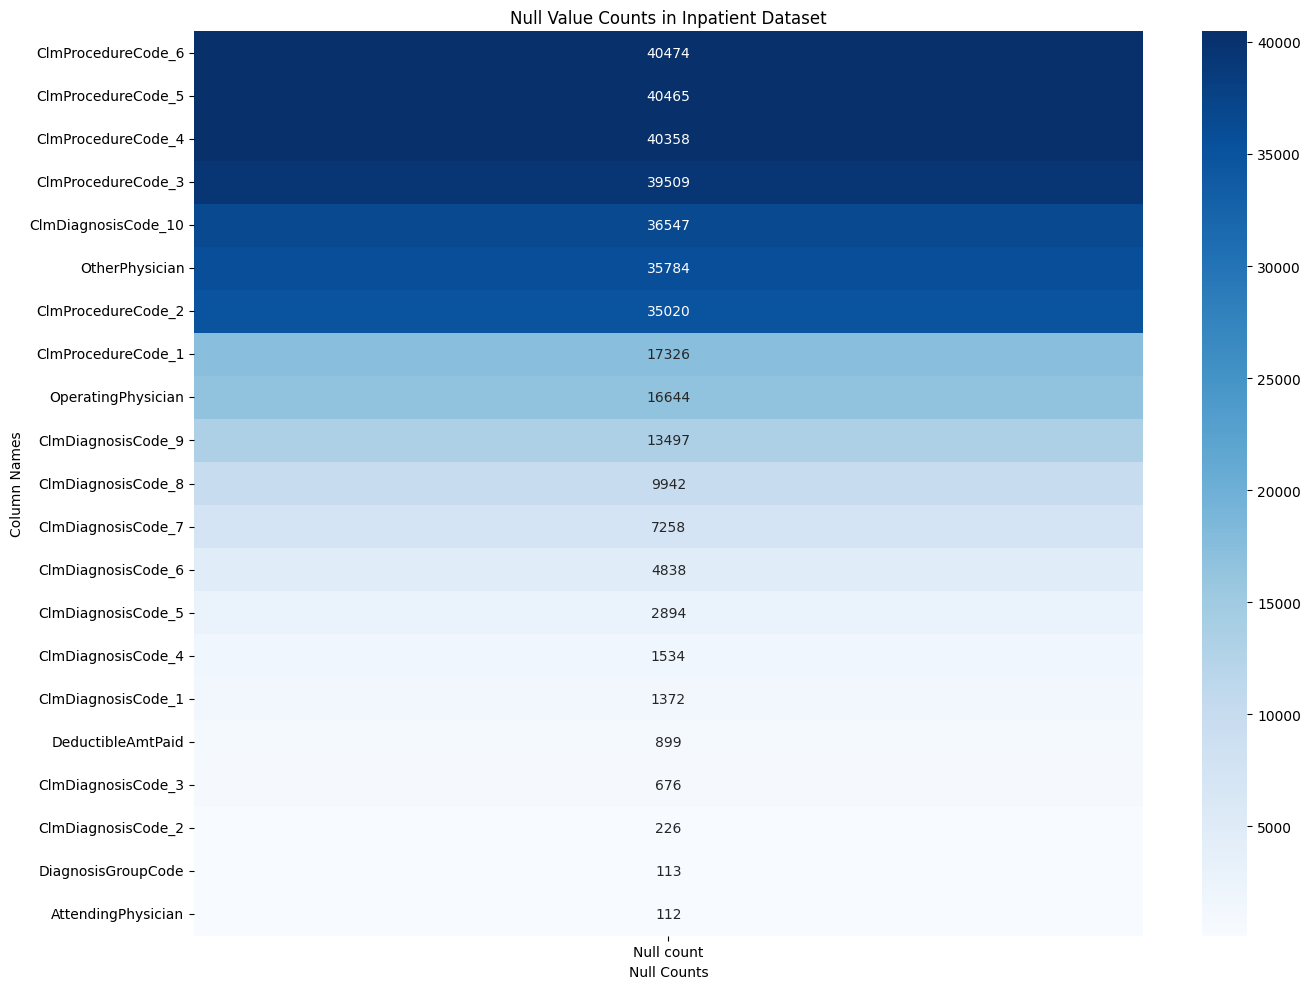

In [125]:
ip_has_nulls_pd = (
    ip_has_nulls
    .sort("Null count", descending=True)
    .to_pandas()
    .set_index("Columns")
)[["Null count"]]

plt.figure(figsize=(14, 10))
sns.heatmap(ip_has_nulls_pd, annot=True, fmt=".0f", cmap='Blues', cbar=True)

plt.xlabel("Null Counts")
plt.ylabel("Column Names")
plt.title("Null Value Counts in Inpatient Dataset")
plt.tight_layout()
plt.show()

In [126]:
train_inpatient = train_inpatient.with_columns(
    pl.lit(1).alias("Admitted?")
)

In [127]:
train_inpatient = train_inpatient.with_columns([
    pl.col("ClaimStartDt").str.strptime(pl.Date, "%Y-%m-%d", strict=False),
    pl.col("ClaimEndDt").str.strptime(pl.Date, "%Y-%m-%d", strict=False)
])

train_inpatient = train_inpatient.with_columns(
    (pl.col("ClaimEndDt") - pl.col("ClaimStartDt")).dt.total_days().alias("Claim_Duration")
)

In [128]:
train_inpatient.select("Claim_Duration").describe()

statistic,Claim_Duration
str,f64
"""count""",40474.0
"""null_count""",0.0
"""mean""",5.660251
"""std""",5.628873
"""min""",0.0
"""25%""",2.0
"""50%""",4.0
"""75%""",7.0
"""max""",36.0


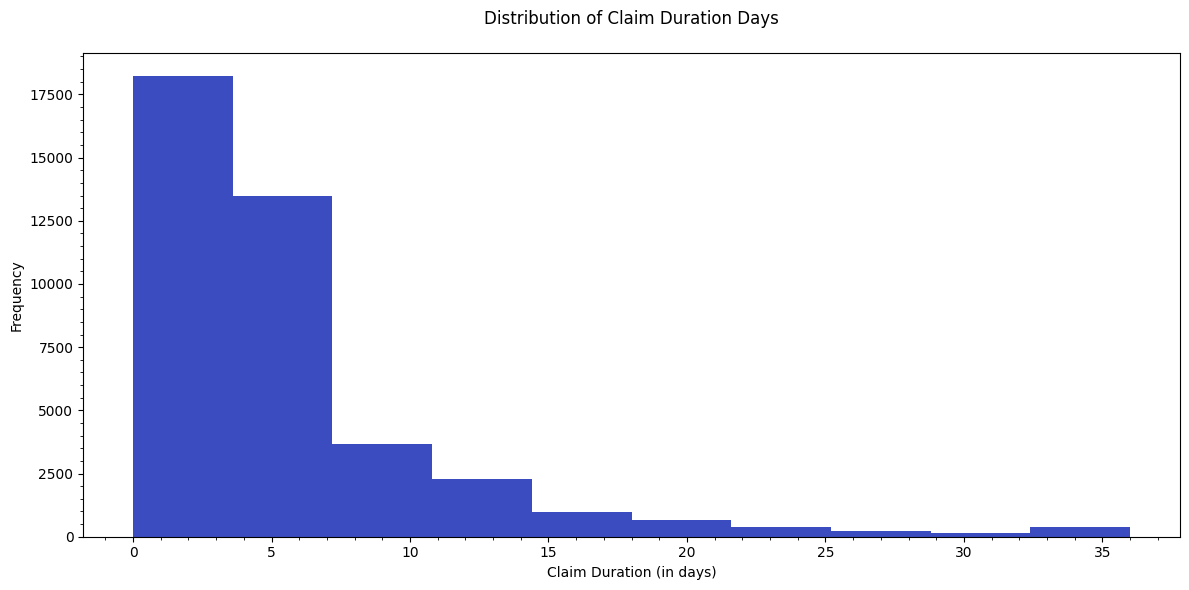

In [129]:
train_inpatient.select("Claim_Duration").to_pandas().plot(
    kind='hist', y="Claim_Duration", colormap="coolwarm", legend=False, figsize=(12, 6)
)
plt.xlabel("Claim Duration (in days)")
plt.minorticks_on()
plt.title("Distribution of Claim Duration Days\n")
plt.tight_layout()
plt.show()

In [130]:
tot_claims = (
    train_inpatient
    .group_by("Claim_Duration")
    .agg(pl.count("BeneID").alias("Total_claims"))
)

In [131]:
tot_reimbursed = (
    train_inpatient
    .group_by("Claim_Duration")
    .agg(pl.sum("InscClaimAmtReimbursed").alias("All_Claims_Total_Amount"))
)


In [132]:
claim_clearance_amts = tot_claims.join(tot_reimbursed, on="Claim_Duration")

In [133]:
claim_clearance_amts = claim_clearance_amts.with_columns(
    (pl.col("All_Claims_Total_Amount") / pl.col("Total_claims"))
    .round(2)
    .alias("Avg_Claim_Insc_Amount")
)

claim_clearance_amts = claim_clearance_amts.rename({
    "Claim_Duration": "Claim_durations_in_days"
})

claim_clearance_amts_pd = claim_clearance_amts.sort("Claim_durations_in_days").to_pandas()

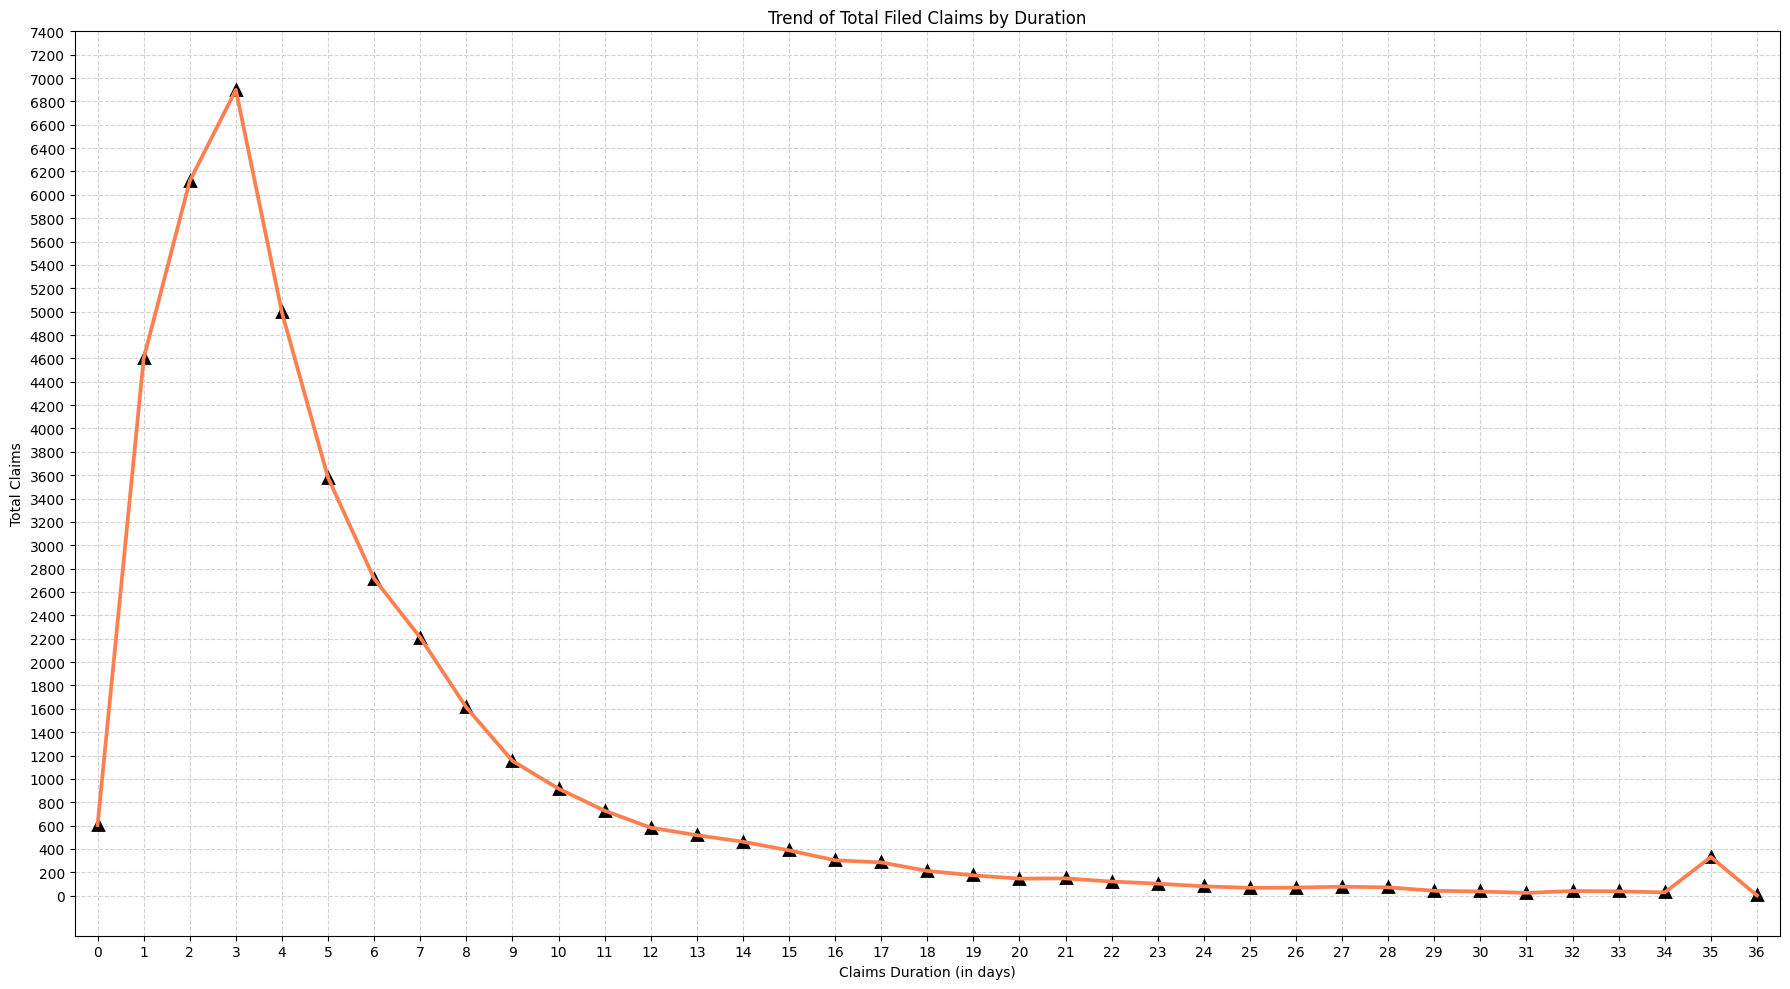

In [134]:
plt.figure(figsize=(18, 10))
sns.pointplot(
    data=claim_clearance_amts_pd, x="Claim_durations_in_days", y="Total_claims",
    color='k', markers="^", linestyles=""
)
sns.pointplot(
    data=claim_clearance_amts_pd, x="Claim_durations_in_days", y="Total_claims",
    color='coral', markers="", linestyles="-"
)

plt.xlabel("Claims Duration (in days)", rotation=0)
plt.ylabel("Total Claims")
plt.yticks(np.arange(0, 7500, 200))
plt.grid(which='major', linestyle="--", color='lightgrey')
plt.title("Trend of Total Filed Claims by Duration")
plt.tight_layout()
plt.show()

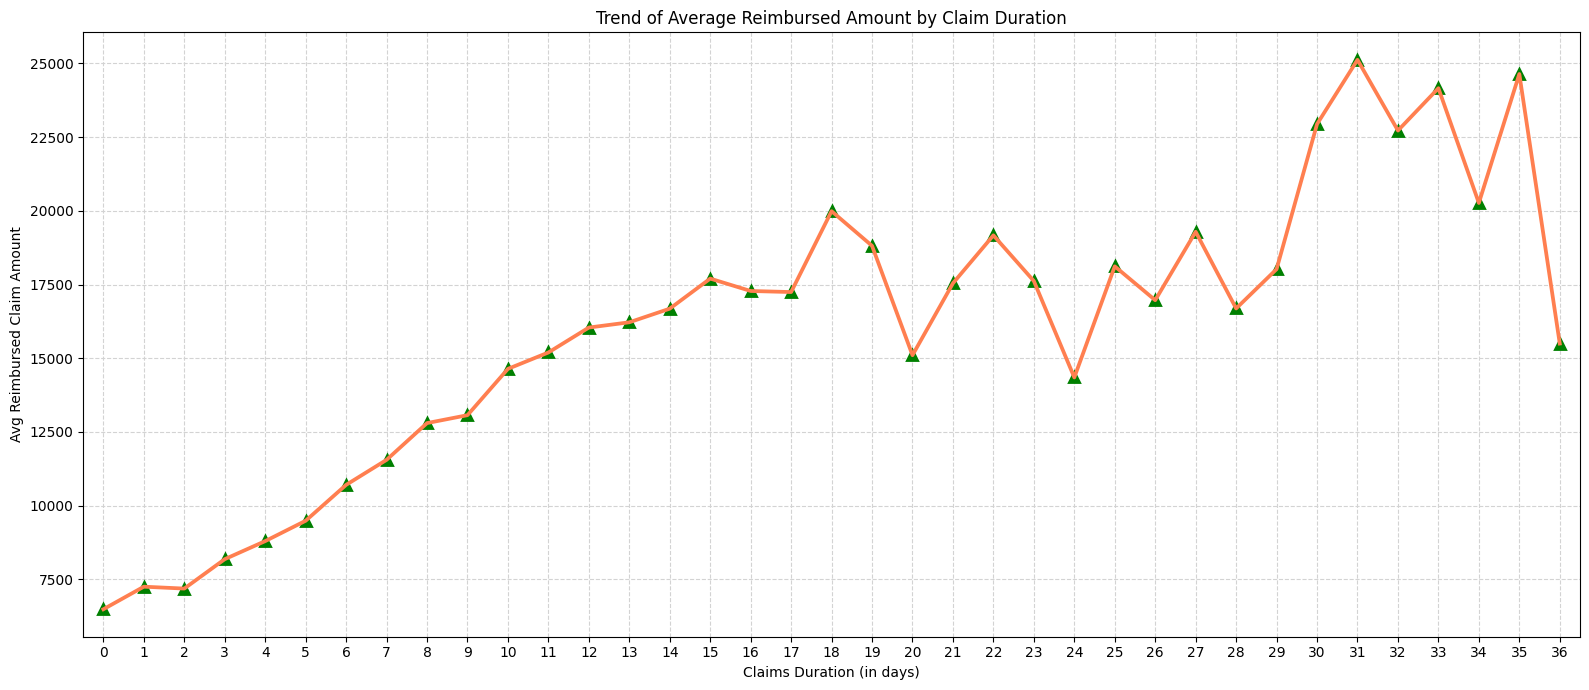

In [135]:
plt.figure(figsize=(16, 7))
sns.pointplot(
    data=claim_clearance_amts_pd, x="Claim_durations_in_days", y="Avg_Claim_Insc_Amount",
    color='green', markers="^", linestyles=""
)
sns.pointplot(
    data=claim_clearance_amts_pd, x="Claim_durations_in_days", y="Avg_Claim_Insc_Amount",
    color='coral', markers="", linestyles="-"
)

plt.xlabel("Claims Duration (in days)")
plt.ylabel("Avg Reimbursed Claim Amount")
plt.grid(which='major', linestyle="--", color='lightgrey')
plt.title("Trend of Average Reimbursed Amount by Claim Duration")
plt.tight_layout()
plt.show()

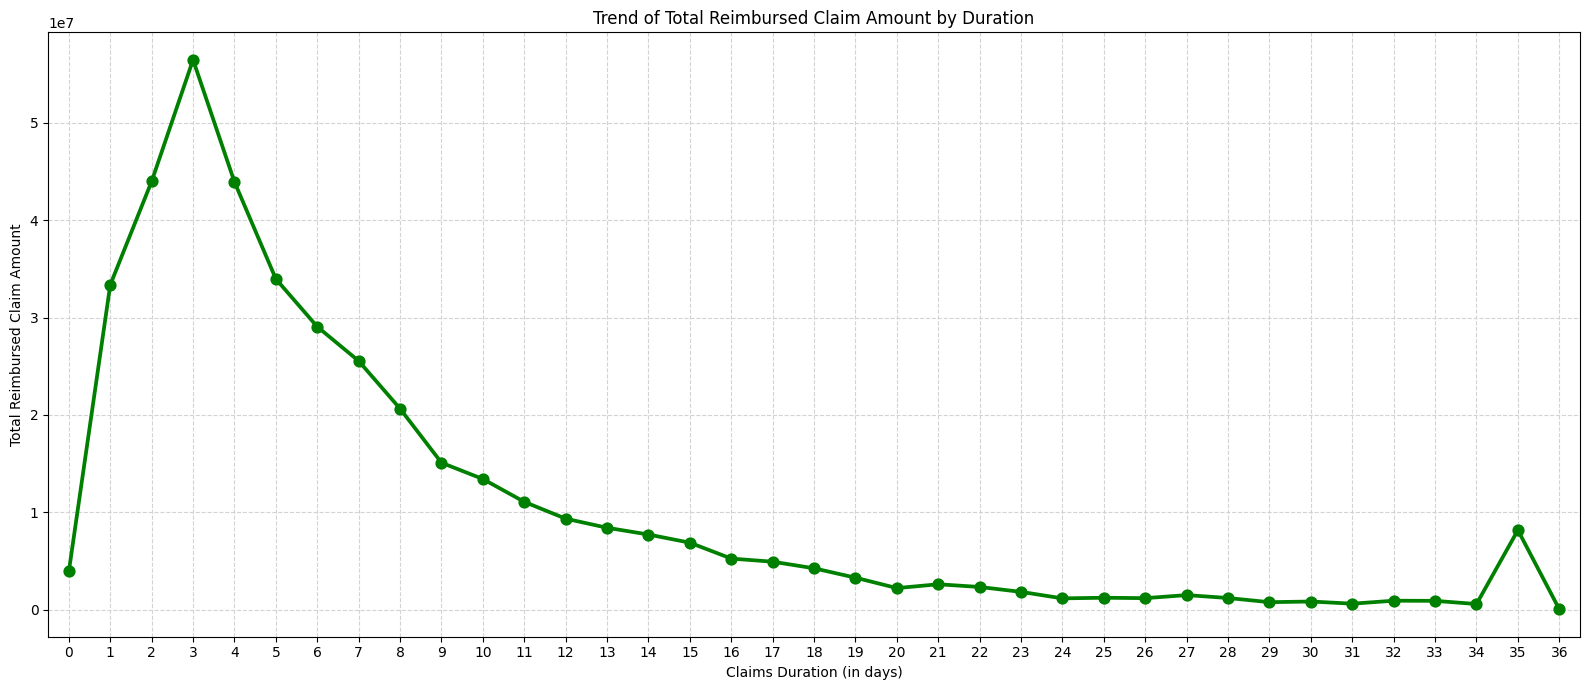

In [136]:
plt.figure(figsize=(16, 7))
sns.pointplot(
    data=claim_clearance_amts_pd, x="Claim_durations_in_days", y="All_Claims_Total_Amount",
    color='green'
)

plt.xlabel("Claims Duration (in days)")
plt.ylabel("Total Reimbursed Claim Amount")
plt.grid(which='major', linestyle="--", color='lightgrey')
plt.title("Trend of Total Reimbursed Claim Amount by Duration")
plt.tight_layout()
plt.show()

In [137]:
train_inpatient = train_inpatient.with_columns([
    pl.col("DischargeDt").str.strptime(pl.Date, "%Y-%m-%d", strict=False),
    pl.col("AdmissionDt").str.strptime(pl.Date, "%Y-%m-%d", strict=False)
])

train_inpatient = train_inpatient.with_columns(
    (pl.col("DischargeDt") - pl.col("AdmissionDt")).dt.total_days().alias("Admitted_Days")
)

claims_with_diff_admitted_and_claimed_dur = train_inpatient.filter(
    pl.col("Claim_Duration") != pl.col("Admitted_Days")
)

In [138]:
claims_with_diff_admitted_and_claimed_dur.select(
    pl.col("InscClaimAmtReimbursed").sum()
).item()

671400

In [139]:
claims_with_duration_greater_than_admitted = claims_with_diff_admitted_and_claimed_dur.filter(
    pl.col("Claim_Duration") > pl.col("Admitted_Days")
)

In [140]:
claims_with_duration_greater_than_admitted

BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,Admitted?,Claim_Duration,Admitted_Days
str,str,date,date,str,i64,str,str,str,date,str,str,date,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i32,i64,i64
"""BENE11093""","""CLM82202""",2009-01-03,2009-01-12,"""PRV51842""",20000,"""PHY341192""","""PHY355416""","""NA""",2009-01-03,"""4439""","""1068""",2009-01-09,255,99662,"""2639""","""E8782""","""920""","""V854""","""4280""","""E9320""","""04185""","""412""","""42732""","""3950""","""2762""","""NA""","""NA""","""NA""","""NA""",1,9,6
"""BENE24807""","""CLM82212""",2008-12-31,2009-01-11,"""PRV54111""",13000,"""PHY360669""","""PHY408812""","""NA""",2008-12-31,"""55221""","""1068""",2009-01-09,345,56889,"""1122""","""40390""","""5185""","""42731""","""9974""","""4589""","""27801""","""25000""","""NA""","""5369""","""NA""","""NA""","""NA""","""NA""","""NA""",1,11,9
"""BENE39346""","""CLM82211""",2009-02-18,2009-02-26,"""PRV54065""",19000,"""PHY337531""","""PHY341176""","""NA""",2009-02-18,"""44421""","""1068""",2009-02-23,254,4422,"""42731""","""60783""","""4019""","""44021""","""V1582""","""2724""","""25040""","""4439""","""27801""","""3712""","""NA""","""NA""","""NA""","""NA""","""NA""",1,8,5
"""BENE44545""","""CLM82209""",2009-01-18,2009-01-27,"""PRV52843""",14000,"""PHY365072""","""NA""","""NA""",2009-01-18,"""85181""","""1068""",2009-01-25,23,85202,"""43411""","""4280""","""25000""","""2449""","""3485""","""78720""","""5070""","""5990""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""",1,9,7
"""BENE47786""","""CLM82208""",2009-05-27,2009-06-04,"""PRV52828""",14000,"""PHY391167""","""NA""","""NA""",2009-05-27,"""486""","""1068""",2009-06-01,166,486,"""412""","""36960""","""60000""","""V140""","""27652""","""53081""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""",1,8,5
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""BENE119908""","""CLM82218""",2009-01-03,2009-01-29,"""PRV57191""",16000,"""PHY329192""","""PHY346614""","""NA""",2009-01-03,"""99649""","""1068""",2009-01-28,453,80502,"""4404""","""V854""","""34690""","""40390""","""V4581""","""E8788""","""V1588""","""70710""","""NA""","""8622""","""NA""","""NA""","""NA""","""NA""","""NA""",1,26,25
"""BENE131263""","""CLM82201""",2009-01-17,2009-01-25,"""PRV51021""",12000,"""PHY424284""","""NA""","""NA""",2009-01-17,"""7802""","""1068""",2009-01-24,76,85226,"""4321""","""4271""","""9150""","""81342""","""7596""","""2948""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""",1,8,7
"""BENE138446""","""CLM82214""",2009-01-08,2009-01-12,"""PRV54955""",11000,"""PHY352488""","""PHY352488""","""NA""",2009-01-08,"""71536""","""1068""",2009-01-10,515,71536,"""V5861""","""53081""","""4019""","""V103""","""41401""","""41400""","""6256""","""NA""","""NA""","""8154""","""NA""","""NA""","""NA""","""NA""","""NA""",1,4,2


In [141]:
claims_with_diff_admitted_and_claimed_dur.filter(
    pl.col("Claim_Duration") > pl.col("Admitted_Days")
).select(
    pl.col("InscClaimAmtReimbursed").sum()
).item()

274000

In [142]:
no_copay_count = train_inpatient.filter(pl.col("DeductibleAmtPaid").is_null()).height

copay_count = train_inpatient.filter(pl.col("DeductibleAmtPaid").is_not_null()).height

total_claims = no_copay_count + copay_count

percent_no_copay = round((no_copay_count / total_claims) * 100, 1)

print(f"Percentage of claims with no co-payment or deductible --> {percent_no_copay}%")

reimbursed_no_copay = train_inpatient.filter(
    pl.col("DeductibleAmtPaid").is_null()
).select(
    pl.col("InscClaimAmtReimbursed").sum()
).item()

reimbursed_with_copay = train_inpatient.filter(
    pl.col("DeductibleAmtPaid").is_not_null()
).select(
    pl.col("InscClaimAmtReimbursed").sum()
).item()

total_reimbursed = reimbursed_no_copay + reimbursed_with_copay

percent_amt_no_copay = round((reimbursed_no_copay / total_reimbursed) * 100, 1)

print(f"Percentage of Total Re-imbursed Amount for claims with no co-payment or deductible --> {percent_amt_no_copay}%")

train_inpatient = train_inpatient.with_columns(
    pl.col("DeductibleAmtPaid").fill_null(0.0)
)

Percentage of claims with no co-payment or deductible --> 0.0%
Percentage of Total Re-imbursed Amount for claims with no co-payment or deductible --> 0.0%


In [143]:
print(f"We have {train_inpatient.select(pl.col('Provider')).n_unique()} unique number of Providers in the in-patient dataset.")

We have 2092 unique number of Providers in the in-patient dataset.


In [144]:
provider_tot_claims_filed = train_inpatient.group_by("Provider").agg([
    pl.count("ClaimID").alias("Tot_Claims_Filed"),
    pl.sum("InscClaimAmtReimbursed").alias("Tot_Re_Imbursed_Amt"),
    pl.max("InscClaimAmtReimbursed").alias("Max_Re_Imbursed_Amt")
])

total_reimbursed = train_inpatient.select(pl.sum("InscClaimAmtReimbursed")).item()

provider_tot_claims_filed = provider_tot_claims_filed.with_columns([
    ((pl.col("Tot_Re_Imbursed_Amt") / total_reimbursed) * 100).round(3).alias("Percentage_out_of_tot_reimb_amt"),
    (pl.col("Tot_Re_Imbursed_Amt") - pl.col("Max_Re_Imbursed_Amt")).alias("Diff_in_Tot_and_Max")
])

provider_tot_claims_filed = provider_tot_claims_filed.sort(
    by=["Diff_in_Tot_and_Max", "Max_Re_Imbursed_Amt", "Percentage_out_of_tot_reimb_amt"],
    descending=[False, True, True]
)

In [145]:
reimb_under_5_claims = provider_tot_claims_filed.filter(pl.col("Tot_Claims_Filed") < 5)

tot_re_imb_amt_for_prv_with_5orless_claims = reimb_under_5_claims.select(pl.sum("Tot_Re_Imbursed_Amt")).item()

total_reimbursed_amt = train_inpatient.select(pl.sum("InscClaimAmtReimbursed")).item()

pp_re_imb_amt_for_prv_with_5orless_claims = round((tot_re_imb_amt_for_prv_with_5orless_claims / total_reimbursed_amt) * 100, 2)


print(f"Total Re-imbursed Amount for Providers with less than 5 filed claims is --> {tot_re_imb_amt_for_prv_with_5orless_claims:,} ({round(tot_re_imb_amt_for_prv_with_5orless_claims/1e6,1)} Million).")
print(f"And, this is {pp_re_imb_amt_for_prv_with_5orless_claims}% of Total Re-imbursed Claim Amount ({round(total_reimbursed_amt/1e6)} Million).")

Total Re-imbursed Amount for Providers with less than 5 filed claims is --> 17,012,550 (17.0 Million).
And, this is 4.17% of Total Re-imbursed Claim Amount (408 Million).


### Out-patients Data

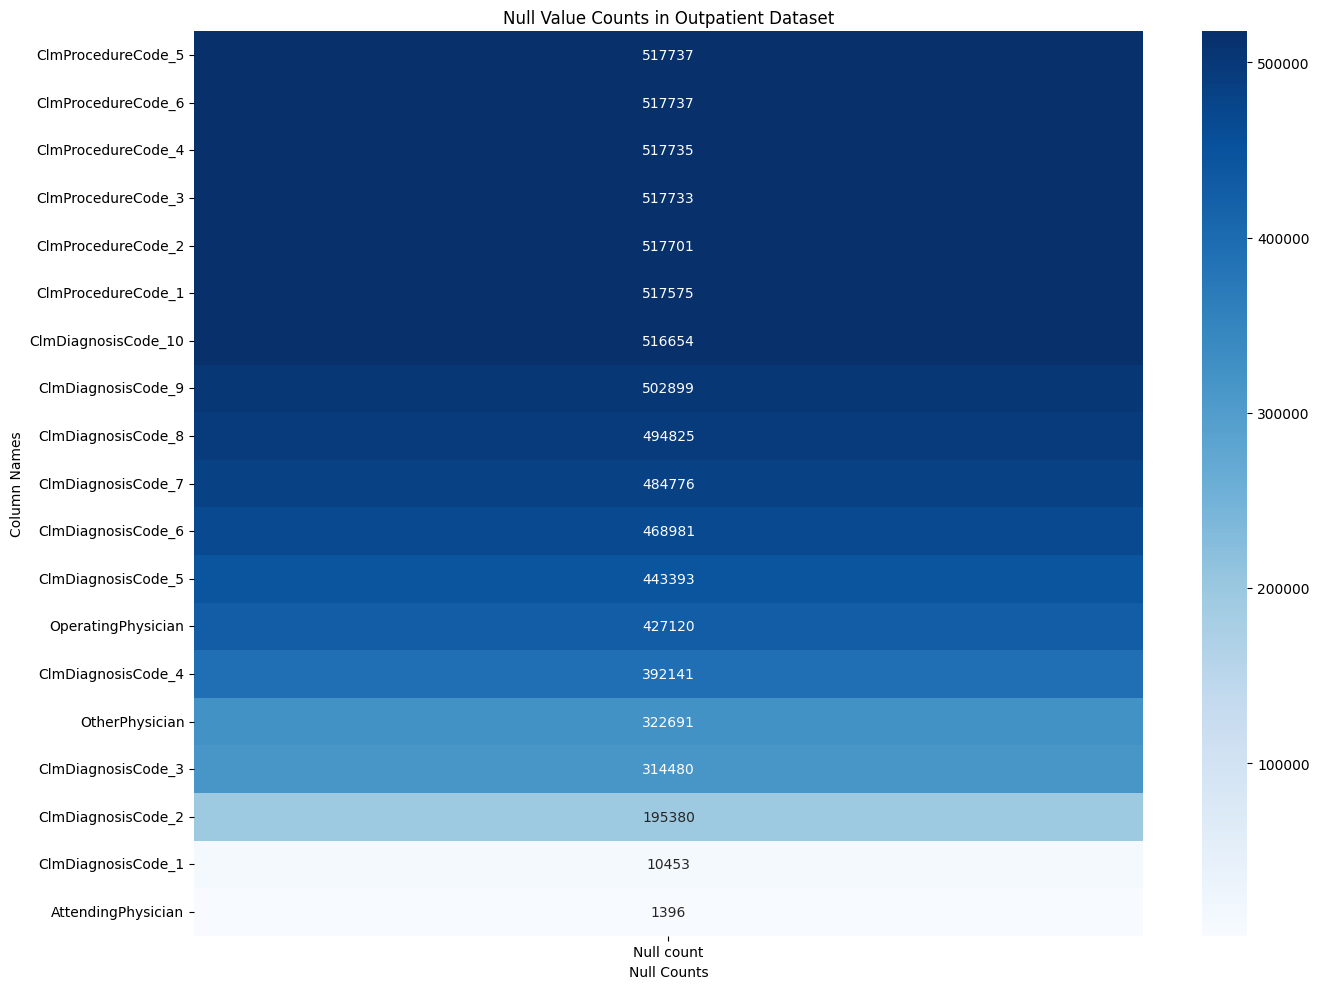

In [146]:
op_has_nulls_pd = (
    op_has_nulls
    .sort("Null count", descending=True)
    .to_pandas()
    .set_index("Columns")
)[["Null count"]]

plt.figure(figsize=(14, 10))
sns.heatmap(op_has_nulls_pd, annot=True, fmt=".0f", cmap='Blues', cbar=True)

plt.xlabel("Null Counts")
plt.ylabel("Column Names")
plt.title("Null Value Counts in Outpatient Dataset")
plt.tight_layout()
plt.show()

In [147]:
train_outpatient = train_outpatient.with_columns(
    pl.lit(0).alias("Admitted?")
)

In [148]:
train_outpatient = train_outpatient.with_columns([
    pl.col("ClaimStartDt").str.strptime(pl.Date, "%Y-%m-%d", strict=False),
    pl.col("ClaimEndDt").str.strptime(pl.Date, "%Y-%m-%d", strict=False)
])

train_outpatient = train_outpatient.with_columns(
    (pl.col("ClaimEndDt") - pl.col("ClaimStartDt")).dt.total_days().alias("Claim_Duration")
)

In [149]:
train_outpatient.select("Claim_Duration").describe()

statistic,Claim_Duration
str,f64
"""count""",517737.0
"""null_count""",0.0
"""mean""",1.420532
"""std""",4.707387
"""min""",0.0
"""25%""",0.0
"""50%""",0.0
"""75%""",0.0
"""max""",23.0


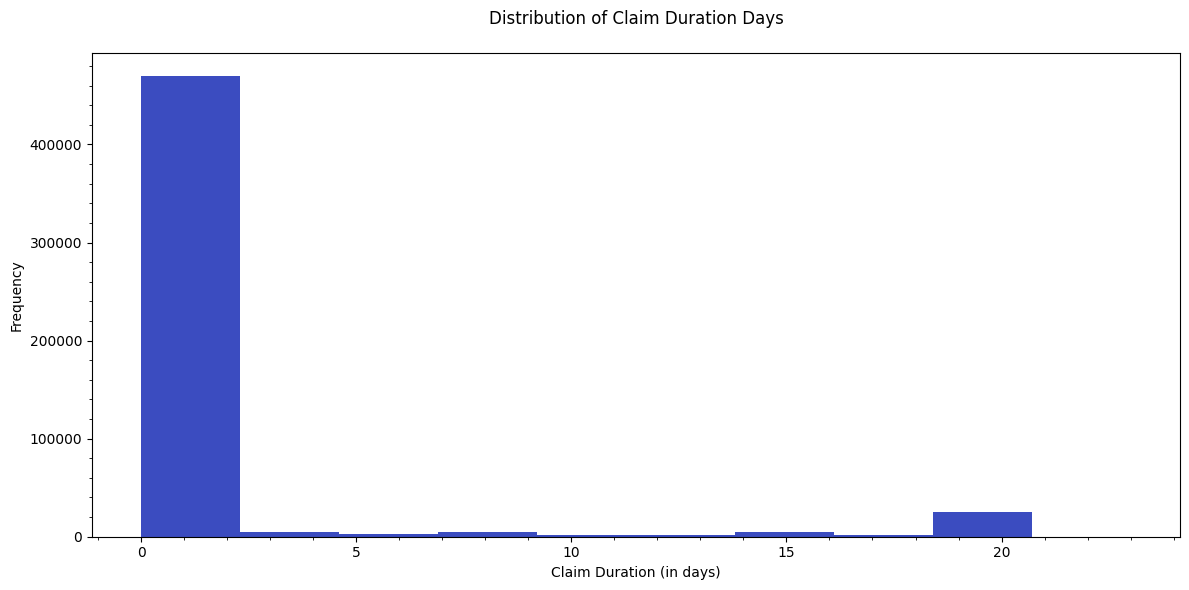

In [150]:
train_outpatient.select("Claim_Duration").to_pandas().plot(
    kind='hist', y="Claim_Duration", colormap="coolwarm", legend=False, figsize=(12, 6)
)
plt.xlabel("Claim Duration (in days)")
plt.minorticks_on()
plt.title("Distribution of Claim Duration Days\n")
plt.tight_layout()
plt.show()

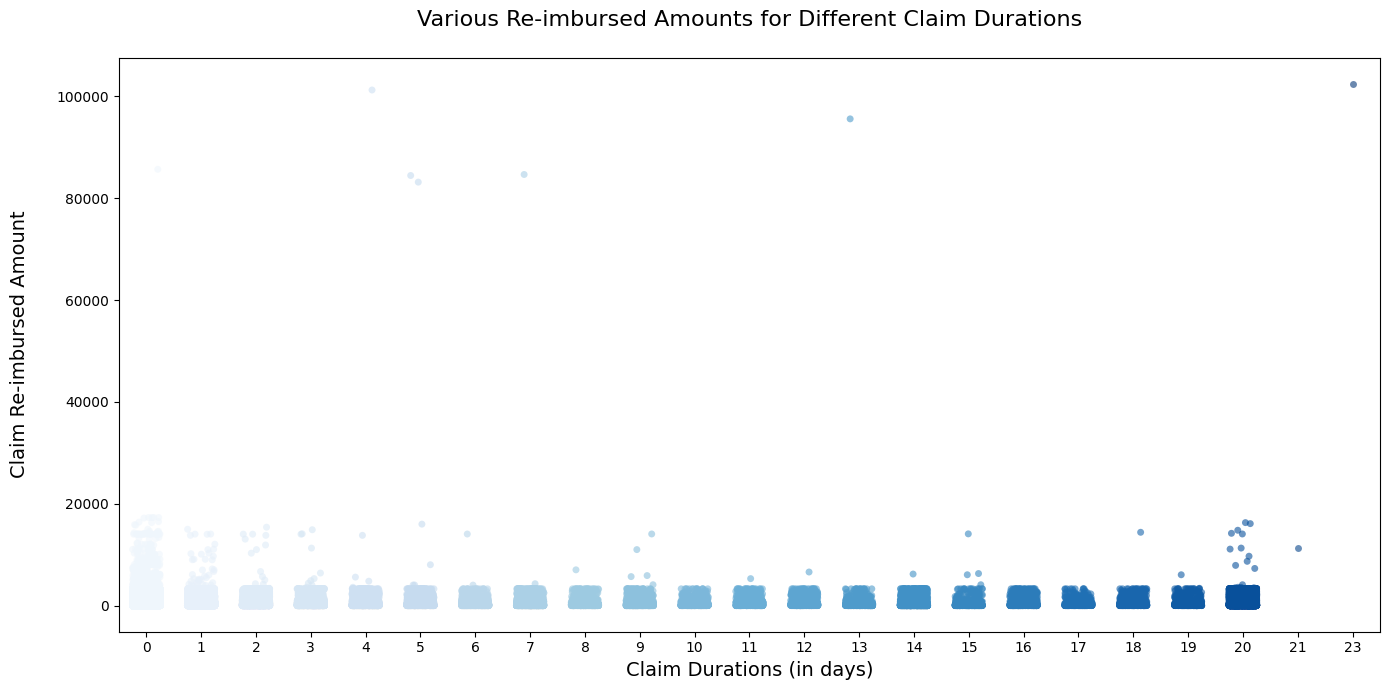

In [153]:
strip_data = train_outpatient.select(["Claim_Duration", "InscClaimAmtReimbursed"]).to_pandas()

plt.figure(figsize=(14, 7))
sns.stripplot(
    x="Claim_Duration",
    y="InscClaimAmtReimbursed",
    data=strip_data,
    palette="Blues",
    jitter=0.25,
    alpha=0.6
)
plt.xlabel("Claim Durations (in days)", fontsize=14)
plt.ylabel("Claim Re-imbursed Amount\n", fontsize=14)
plt.title("Various Re-imbursed Amounts for Different Claim Durations\n", fontsize=16)
plt.tight_layout()
plt.show()

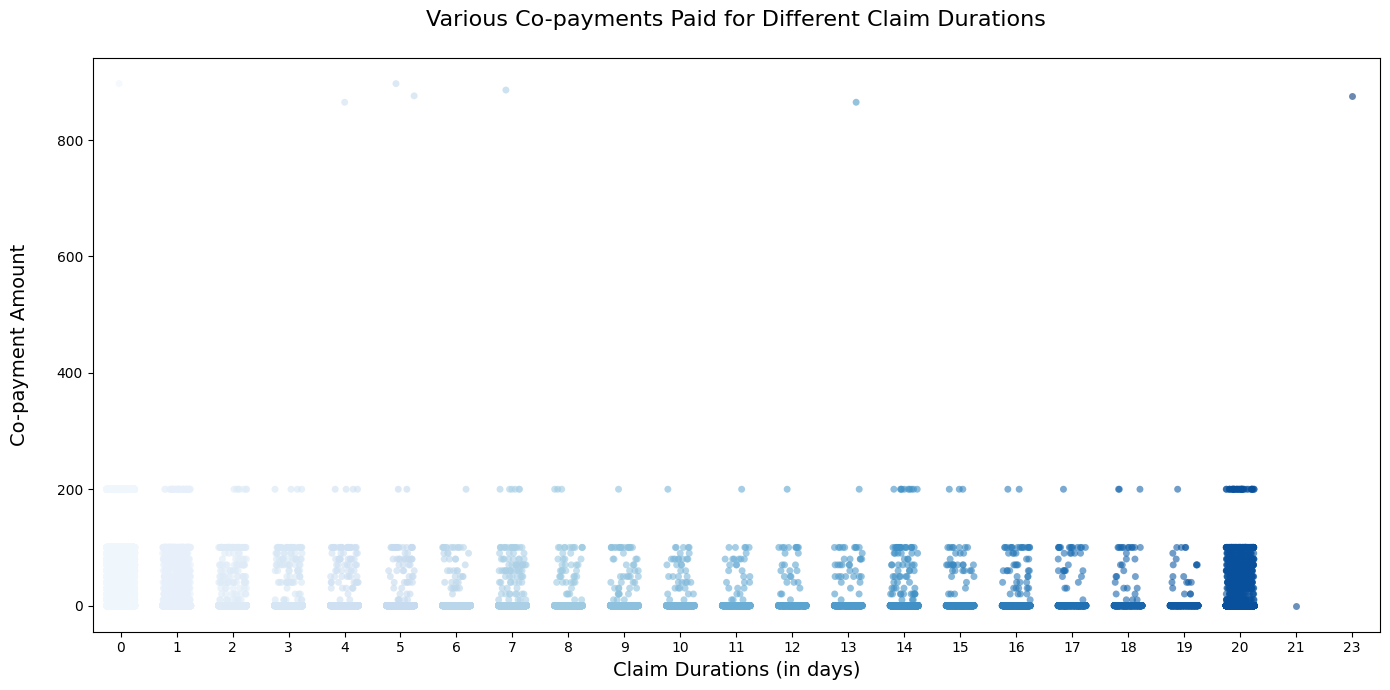

In [155]:
strip_data = train_outpatient.select(["Claim_Duration", "DeductibleAmtPaid"]).to_pandas()

plt.figure(figsize=(14, 7))
sns.stripplot(
    x="Claim_Duration",
    y="DeductibleAmtPaid",
    data=strip_data,
    palette="Blues",
    jitter=0.25,
    alpha=0.6
)

plt.xlabel("Claim Durations (in days)", fontsize=14)
plt.ylabel("Co-payment Amount\n", fontsize=14)
plt.title("Various Co-payments Paid for Different Claim Durations\n", fontsize=16)
plt.tight_layout()
plt.show()

In [157]:
claim_clearance_amts = (
    train_outpatient
    .group_by("Claim_Duration")
    .agg([
        pl.count("ClaimID").alias("Total_claims"),
        pl.sum("InscClaimAmtReimbursed").alias("All_Claims_Total_Amount")
    ])
    .with_columns([
        (pl.col("All_Claims_Total_Amount") / pl.col("Total_claims"))
        .round(2)
        .alias("Avg_Claim_Insc_Amount")
    ])
    .sort("Claim_Duration")
)

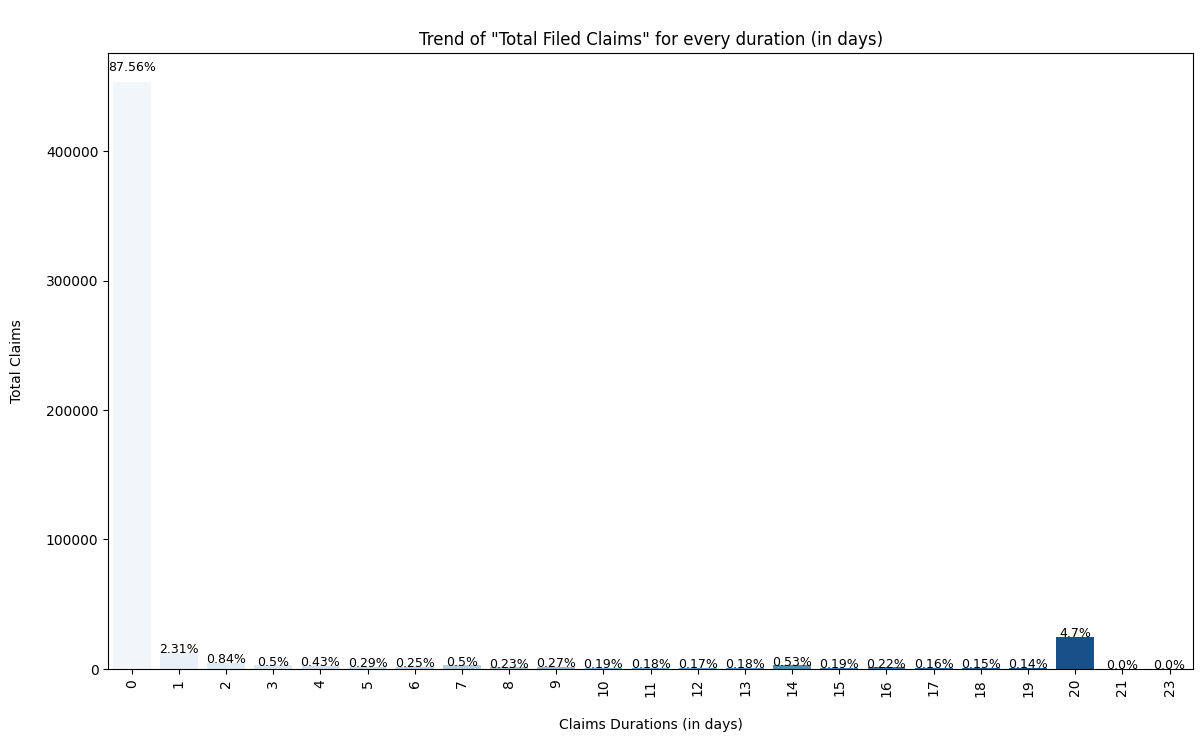

In [163]:
claim_clearance_amts_pd = claim_clearance_amts.to_pandas()

plt.figure(figsize=(14, 8))
fig = sns.barplot(
    data=claim_clearance_amts_pd, 
    x='Claim_Duration', 
    y='Total_claims', 
    palette='Blues'
)

total_claims = claim_clearance_amts_pd["Total_claims"].sum()
for p in fig.patches:
    height = p.get_height()
    x = p.get_x() + p.get_width() / 2
    fig.annotate(
        f'{round((height * 100) / total_claims, 2)}%', 
        (x, height * 1.02), 
        ha='center', 
        fontsize=9
    )

plt.xticks(rotation=90)
plt.xlabel("\nClaims Durations (in days)")
plt.ylabel("Total Claims\n")
plt.title('\nTrend of "Total Filed Claims" for every duration (in days)')
plt.show()

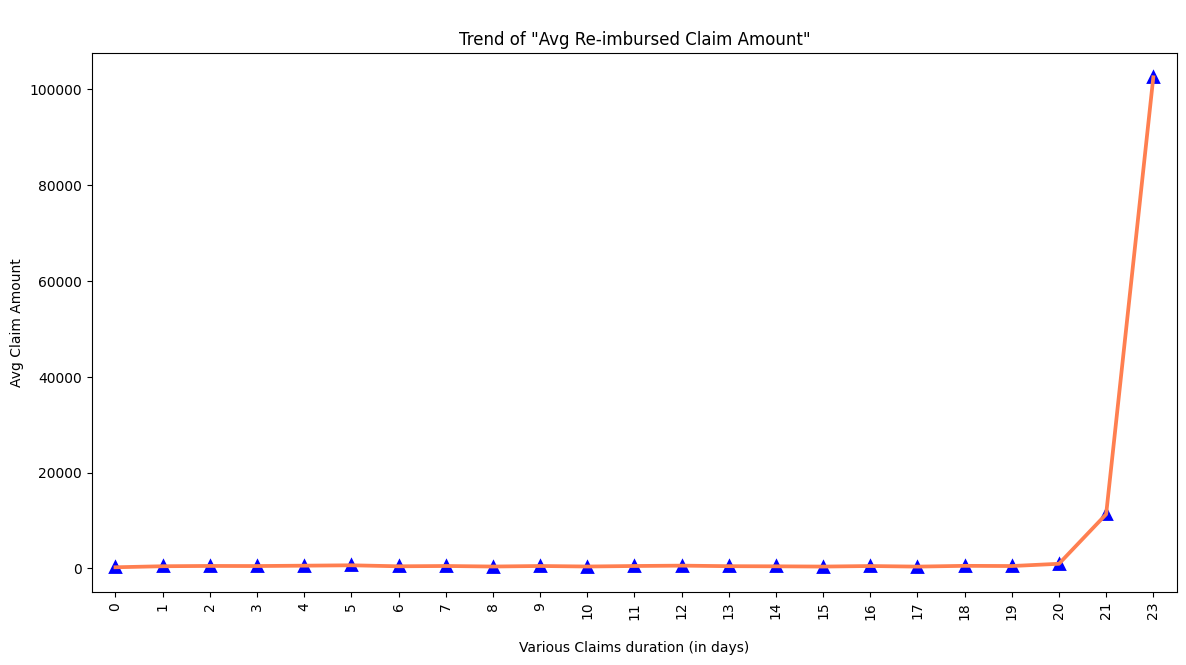

In [164]:
claim_clearance_amts_pd = claim_clearance_amts.to_pandas()

plt.figure(figsize=(14, 7))

sns.pointplot(
    data=claim_clearance_amts_pd,
    x='Claim_Duration',
    y='Avg_Claim_Insc_Amount',
    color='blue',
    markers="^",
    linestyles=""
)

sns.pointplot(
    data=claim_clearance_amts_pd,
    x='Claim_Duration',
    y='Avg_Claim_Insc_Amount',
    color='coral',
    markers="",
    linestyles="-"
)

plt.xticks(rotation=90)
plt.xlabel("\nVarious Claims duration (in days)")
plt.ylabel("Avg Claim Amount")
plt.title('\nTrend of "Avg Re-imbursed Claim Amount"')
plt.show()

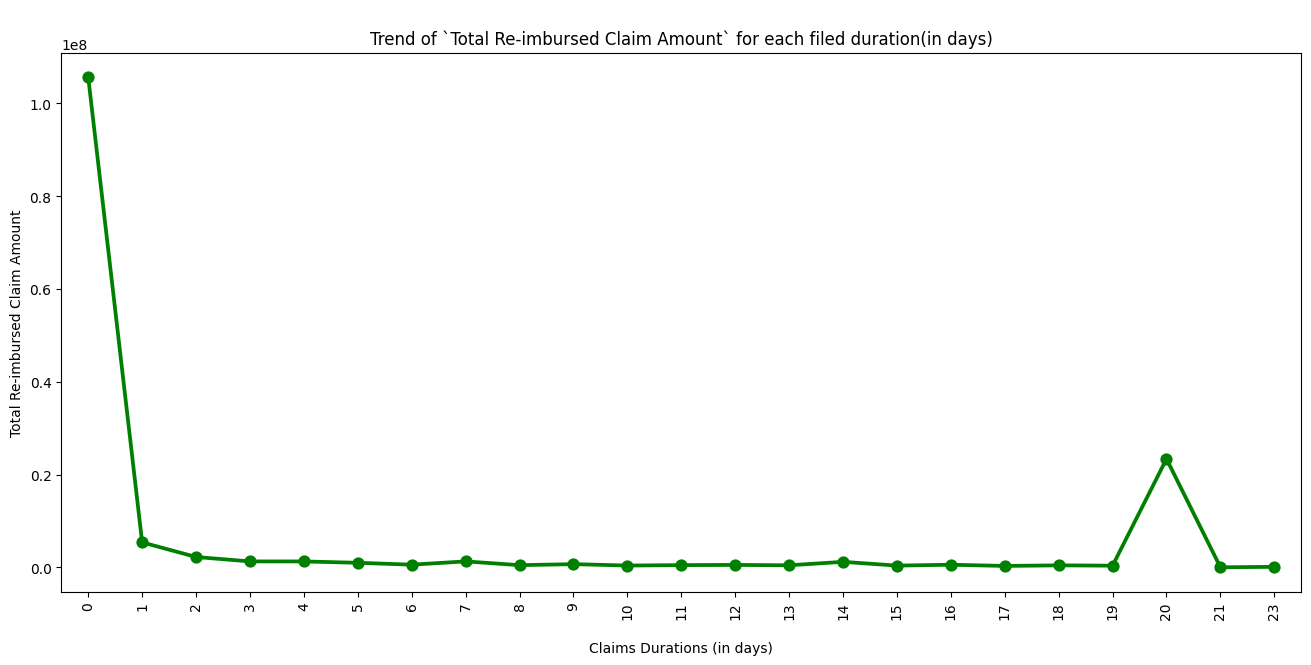

In [168]:
plt.figure(figsize=(16, 7))

sns.pointplot(
    data=claim_clearance_amts_pd,
    x='Claim_Duration',
    y='All_Claims_Total_Amount',
    color='green'
)

plt.xticks(rotation=90)
plt.xlabel("\nClaims Durations (in days)")
plt.ylabel("Total Re-imbursed Claim Amount")
plt.title("\nTrend of `Total Re-imbursed Claim Amount` for each filed duration(in days)")
plt.show()

In [169]:
no_copay_count = train_outpatient.filter(pl.col("DeductibleAmtPaid") == 0).shape[0]
with_copay_count = train_outpatient.filter(pl.col("DeductibleAmtPaid") != 0).shape[0]

total_claims = no_copay_count + with_copay_count
percent_no_copay_claims = round((no_copay_count / total_claims) * 100, 1)

print(f"Percentage of claims with no co-payment or deductible --> {percent_no_copay_claims}%")

reimb_no_copay = train_outpatient.filter(pl.col("DeductibleAmtPaid") == 0).select(pl.sum("InscClaimAmtReimbursed")).item()
reimb_with_copay = train_outpatient.filter(pl.col("DeductibleAmtPaid") != 0).select(pl.sum("InscClaimAmtReimbursed")).item()


total_reimb = reimb_no_copay + reimb_with_copay
percent_reimb_no_copay = round((reimb_no_copay / total_reimb) * 100, 1)

print(f"Percentage of Total Re-imbursed Amount for claims with no co-payment or deductible --> {percent_reimb_no_copay}%")

Percentage of claims with no co-payment or deductible --> 95.9%
Percentage of Total Re-imbursed Amount for claims with no co-payment or deductible --> 96.1%


In [170]:
print(f"We have {train_outpatient.select(pl.col('Provider')).n_unique()} unique number of Providers in the in-patient dataset.")

We have 5012 unique number of Providers in the in-patient dataset.


In [171]:
provider_tot_claims_filed = train_outpatient.group_by("Provider").agg([
    pl.count("ClaimID").alias("Tot_Claims_Filed"),
    pl.sum("InscClaimAmtReimbursed").alias("Tot_Re_Imbursed_Amt"),
    pl.max("InscClaimAmtReimbursed").alias("Max_Re_Imbursed_Amt")
])

total_reimbursed = train_outpatient.select(pl.sum("InscClaimAmtReimbursed")).item()

provider_tot_claims_filed = provider_tot_claims_filed.with_columns([
    ((pl.col("Tot_Re_Imbursed_Amt") / total_reimbursed) * 100).round(3).alias("Percentage_out_of_tot_reimb_amt"),
    (pl.col("Tot_Re_Imbursed_Amt") - pl.col("Max_Re_Imbursed_Amt")).alias("Diff_in_Tot_and_Max")
])

provider_tot_claims_filed = provider_tot_claims_filed.sort(
    by=["Diff_in_Tot_and_Max", "Max_Re_Imbursed_Amt", "Percentage_out_of_tot_reimb_amt"],
    descending=[False, True, True]
)

In [172]:
reimb_under_5_claims = provider_tot_claims_filed.filter(pl.col("Tot_Claims_Filed") < 5)

tot_re_imb_amt_for_prv_with_5orless_claims = reimb_under_5_claims.select(pl.sum("Tot_Re_Imbursed_Amt")).item()

total_reimbursed_amt = train_outpatient.select(pl.sum("InscClaimAmtReimbursed")).item()

pp_re_imb_amt_for_prv_with_5orless_claims = round((tot_re_imb_amt_for_prv_with_5orless_claims / total_reimbursed_amt) * 100, 2)


print(f"Total Re-imbursed Amount for Providers with less than 5 filed claims is --> {tot_re_imb_amt_for_prv_with_5orless_claims:,} ({round(tot_re_imb_amt_for_prv_with_5orless_claims/1e6,1)} Million).")
print(f"And, this is {pp_re_imb_amt_for_prv_with_5orless_claims}% of Total Re-imbursed Claim Amount ({round(total_reimbursed_amt/1e6)} Million).")

Total Re-imbursed Amount for Providers with less than 5 filed claims is --> 522,910 (0.5 Million).
And, this is 0.35% of Total Re-imbursed Claim Amount (148 Million).


As part of the exploratory data analysis (EDA) for in-patient (IP) and out-patient (OP) claims, the following new features were derived to enhance the downstream fraud detection pipeline:

**Claim Duration**: The total number of days between ClaimStartDt and ClaimEndDt.

**Admitted Duration**: Specifically for in-patient data, the number of days between AdmissionDt and DischargeDt.

**Admitted Indicator**: A binary flag denoting whether a patient was admitted or not (relevant primarily for IP data).

The following complex relationships are hypothesized to play a role in identifying potential fraudulent behaviors. These will be validated through further statistical analysis and modeling:

**Provider ↔ Physicians ↔ Fraud Indicator**
Certain providers consistently working with the same set of physicians may indicate collusion or unusual claim activity.

**Provider ↔ Physicians ↔ Diagnosis & Procedure Codes ↔ Fraud Indicator**
Anomalies in medical coding patterns (e.g., frequent use of high-cost codes) tied to specific provider-physician combinations can hint at upcoding or unnecessary procedures.

Low-Volume, High-Reimbursement Providers ↔ Fraud Indicator
Providers submitting a disproportionately small number of claims but receiving unusually high reimbursements may be attempting to exploit billing codes or commit targeted fraud.